In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc3 as pm
import seaborn as sns
import theano.tensor as tt
import warnings

from scipy import stats
from scipy.special import expit as logistic
from scipy.special import softmax
from sklearn.preprocessing import MinMaxScaler

%config InlineBackend.figure_format = 'retina'
warnings.simplefilter(action="ignore", category=FutureWarning)
RANDOM_SEED = 8927
np.random.seed(286)

In [2]:
az.style.use("arviz-darkgrid")
az.rcParams['stats.credible_interval'] = 0.89

def standardize(series):
    """Standardize a pandas series"""
    return (series - series.mean()) / series.std()

#### Code 11.1

In [25]:
d = pd.read_csv('Data/chimpanzees.csv', sep=";")
# we change "actor" to zero-index
d.actor = d.actor - 1
d

,actor,recipient,condition,block,trial,prosoc_left,chose_prosoc,pulled_left
0,0,NaN,0,1,2,0,1,0
1,0,NaN,0,1,4,0,0,1
2,0,NaN,0,1,6,1,0,0
3,0,NaN,0,1,8,0,1,0
4,0,NaN,0,1,10,1,1,1
...,...,...,...,...,...,...,...,...
499,6,4.0,1,6,64,1,1,1
500,6,6.0,1,6,66,1,1,1
501,6,3.0,1,6,68,0,0,1
502,6,7.0,1,6,70,0,0,1


#### Code 11.2

In [26]:
d["treatment"] = d.prosoc_left + 2 * d.condition
d[["actor", "prosoc_left", "condition", "treatment"]]

,actor,prosoc_left,condition,treatment
0,0,0,0,0
1,0,0,0,0
2,0,1,0,1
3,0,0,0,0
4,0,1,0,1
...,...,...,...,...
499,6,1,1,3
500,6,1,1,3
501,6,0,1,2
502,6,0,1,2


#### Code 11.4 and 11.5

In [27]:
with pm.Model() as m11_1:
    a = pm.Normal('a', 0., 10.)
    p = pm.Deterministic("p", pm.math.invlogit(a))
    pulled_left = pm.Binomial('pulled_left', 1, p, observed=d.pulled_left)

    prior_11_1 = pm.sample_prior_predictive(random_seed=RANDOM_SEED)
idata_11_1 = az.from_pymc3(prior=prior_11_1)

with pm.Model() as m11_1bis:
    a = pm.Normal('a', 0., 1.5)
    p = pm.Deterministic("p", pm.math.invlogit(a))
    pulled_left = pm.Binomial('pulled_left', 1, p, observed=d.pulled_left)

    prior_11_1bis = pm.sample_prior_predictive(random_seed=RANDOM_SEED)
idata_11_1bis = az.from_pymc3(prior=prior_11_1bis)

#### Code 11.6

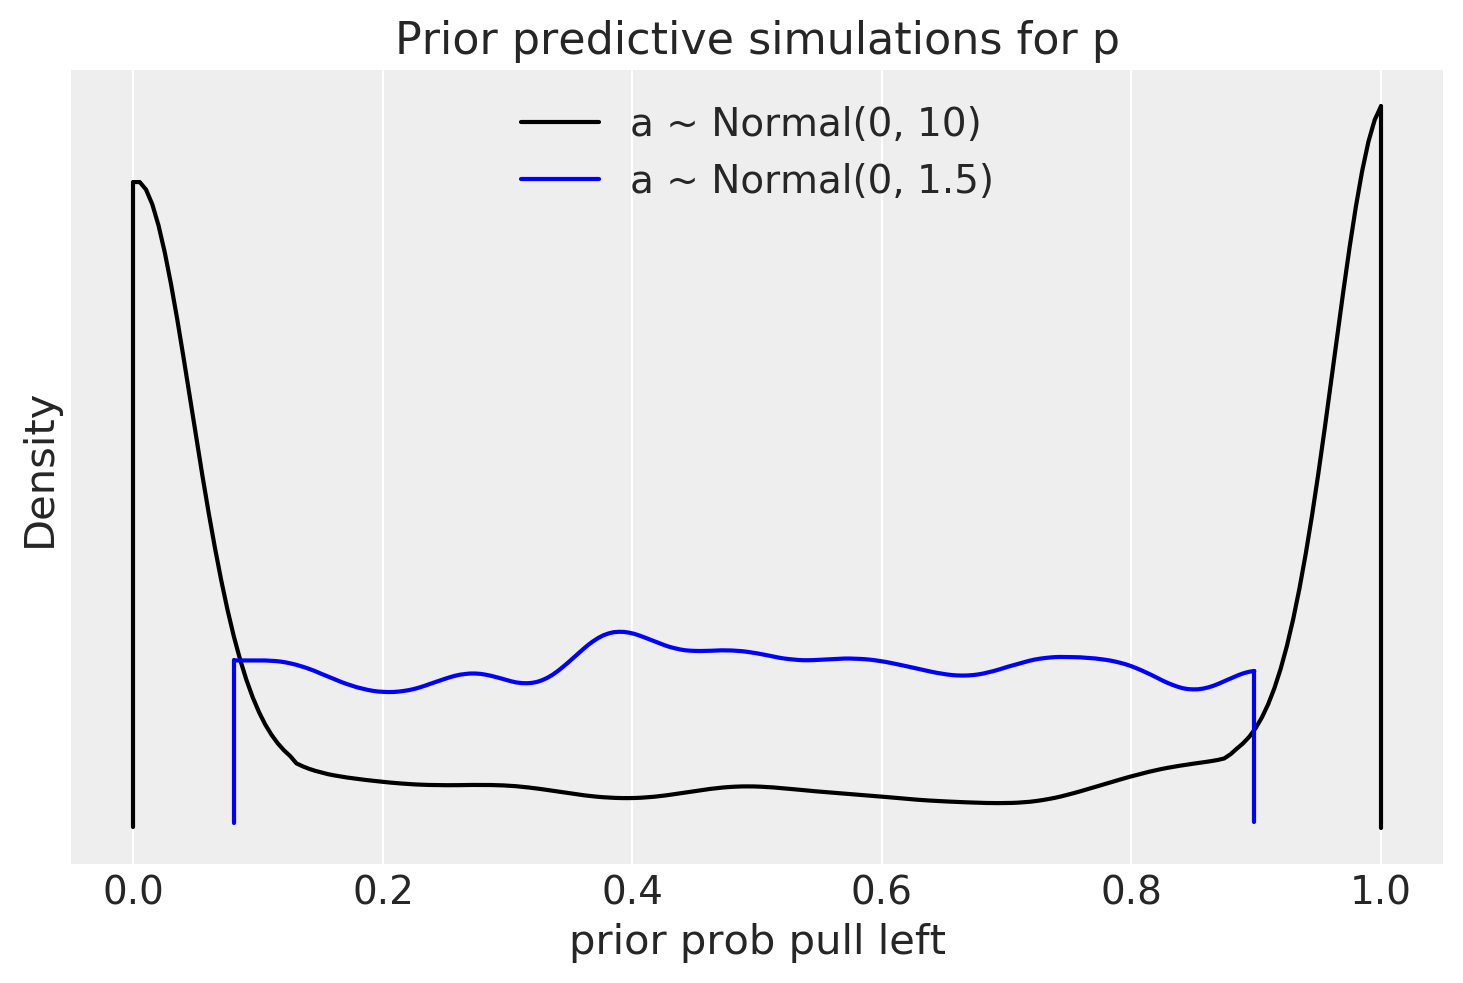

In [28]:
ax = az.plot_density([idata_11_1, idata_11_1bis], data_labels=["a ~ Normal(0, 10)", "a ~ Normal(0, 1.5)"], group="prior", colors=["k", "b"], var_names=["p"], point_estimate=None)
ax[0].set_xlabel("prior prob pull left")
ax[0].set_ylabel("Density")
ax[0].set_title("Prior predictive simulations for p");

#### Code 11.7

In [29]:
with pm.Model() as m11_2:
    a = pm.Normal('a', 0., 1.5)
    b = pm.Normal('b', 0., 10., shape=4)
    
    p = pm.math.invlogit(a + b[d.treatment])
    pulled_left = pm.Binomial('pulled_left', 1, p, observed=d.pulled_left)

    prior_11_2 = pm.sample_prior_predictive(random_seed=RANDOM_SEED)
idata_11_2 = az.from_pymc3(prior=prior_11_2)
prior_2 = idata_11_2.prior

with pm.Model() as m11_3:
    a = pm.Normal('a', 0., 1.5)
    b = pm.Normal('b', 0., 0.5, shape=4)
    
    p = pm.math.invlogit(a + b[d.treatment])
    pulled_left = pm.Binomial('pulled_left', 1, p, observed=d.pulled_left)

    prior_11_3 = pm.sample_prior_predictive(random_seed=RANDOM_SEED)
idata_11_3 = az.from_pymc3(prior=prior_11_3)
prior_3 = idata_11_3.prior

#### Code 11.8

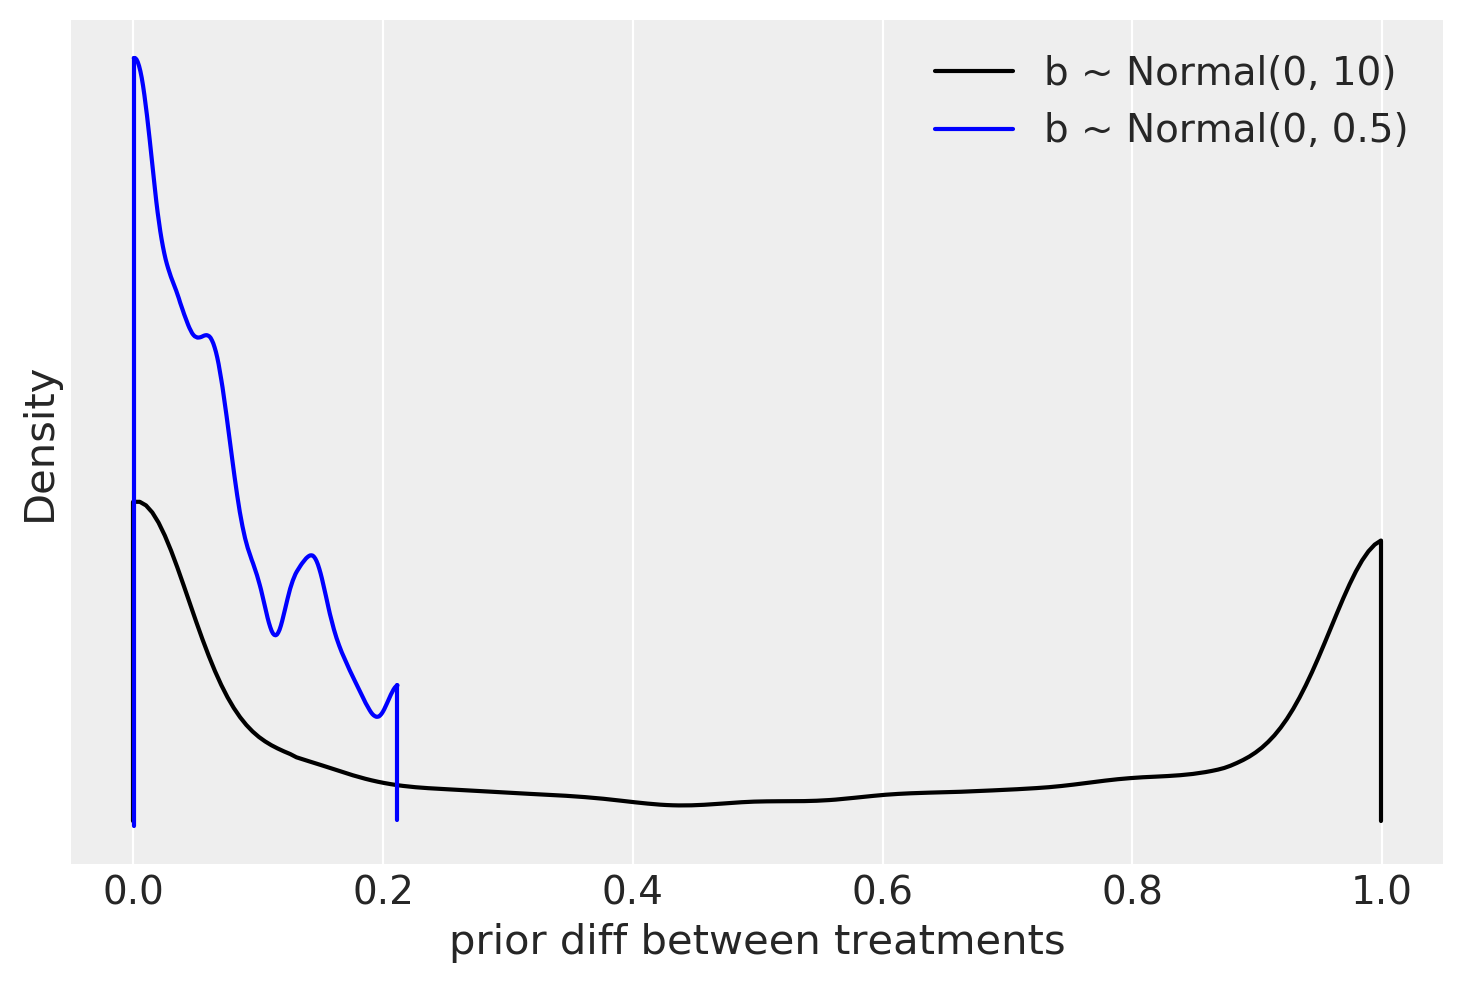

In [30]:
p_treat1, p_treat2 = logistic(prior_2["a"] + prior_2["b"].sel(b_dim_0 = 0)), logistic(prior_2["a"] + prior_2["b"].sel(b_dim_0 = 1))
p_treat1_bis, p_treat2_bis = logistic(prior_3["a"] + prior_3["b"].sel(b_dim_0 = 0)), logistic(prior_3["a"] + prior_3["b"].sel(b_dim_0 = 1))

ax = az.plot_density([np.abs(p_treat1 - p_treat2).values, np.abs(p_treat1_bis - p_treat2_bis).values], 
                     data_labels=["b ~ Normal(0, 10)", "b ~ Normal(0, 0.5)"], group="prior", colors=["k", "b"], point_estimate=None)
ax[0].set_xlabel("prior diff between treatments")
ax[0].set_ylabel("Density")
ax[0].set_title(None);

#### Code 11.9

In [31]:
np.abs(p_treat1_bis - p_treat2_bis).mean().values

array(0.09629389)

#### Code 11.10

In [32]:
actor_idx, actors = pd.factorize(d.actor)
treat_idx, treatments = pd.factorize(d.treatment)

#### Code 11.11

In [33]:
with pm.Model() as m11_4:
    a = pm.Normal('a', 0., 1.5, shape=len(actors))
    b = pm.Normal('b', 0., 0.5, shape=len(treatments))
    
    actor_id = pm.intX(pm.Data("actor_id", actor_idx))
    treat_id = pm.intX(pm.Data("treat_id", treat_idx))
    p = pm.Deterministic("p", pm.math.invlogit(a[actor_id] + b[treat_id]))
    
    pulled_left = pm.Binomial('pulled_left', 1, p, observed=d.pulled_left)

    trace_11_4 = pm.sample(tune=1000, random_seed=RANDOM_SEED)
idata_11_4 = az.from_pymc3(trace_11_4)
az.summary(idata_11_4, var_names=["a", "b"], round_to=2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, a]


,mean,sd,hpd_5.5%,hpd_94.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
a[0],-0.45,0.34,-0.98,0.10,0.01,0.01,904.02,904.02,906.49,1233.25,1.0
a[1],3.89,0.77,2.70,5.16,0.02,0.01,1662.46,1519.62,1727.43,1041.72,1.0
a[2],-0.76,0.34,-1.32,-0.26,0.01,0.01,920.71,901.91,923.84,1220.99,1.0
a[3],-0.76,0.33,-1.27,-0.21,0.01,0.01,921.17,899.91,925.35,1402.90,1.0
a[4],-0.46,0.33,-0.99,0.05,0.01,0.01,804.67,804.67,803.08,1264.72,1.0
a[5],0.47,0.33,-0.07,0.95,0.01,0.01,985.84,985.84,981.28,1329.78,1.0
a[6],1.94,0.42,1.26,2.57,0.01,0.01,1199.67,1185.58,1201.59,1482.44,1.0
b[0],-0.04,0.29,-0.52,0.39,0.01,0.01,778.84,778.84,773.57,1272.13,1.0
b[1],0.48,0.29,0.05,0.96,0.01,0.01,807.97,776.91,807.51,1151.41,1.0
b[2],-0.38,0.29,-0.84,0.08,0.01,0.01,828.71,828.71,828.68,1342.87,1.0


#### Code 11.12

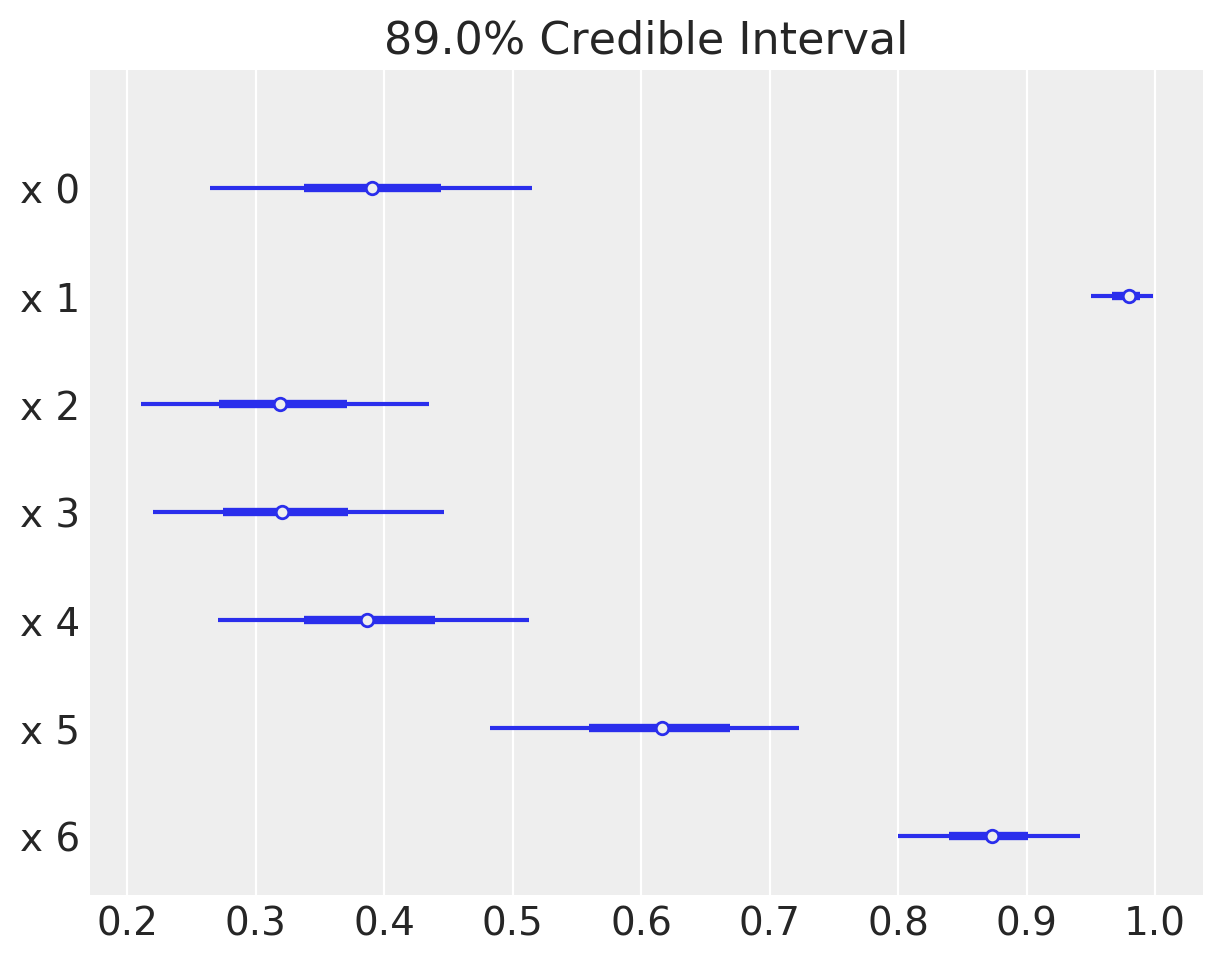

In [34]:
post = idata_11_4.posterior
p_left = logistic(post["a"])
az.plot_forest(p_left.values, combined=True);

#### Code 11.13

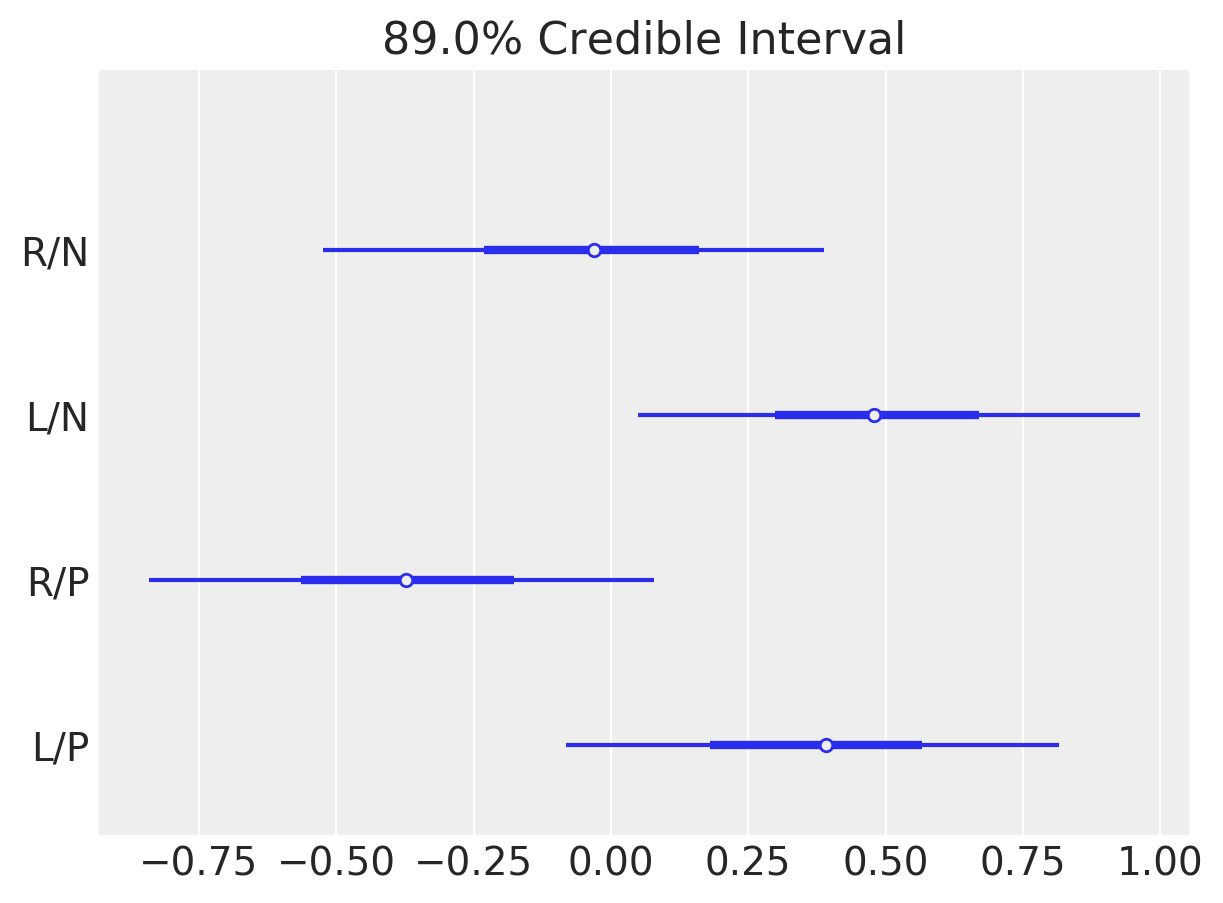

In [35]:
ax = az.plot_forest(idata_11_4, var_names=["b"], combined=True)
ax[0].set_yticklabels(["L/P", "R/P", "L/N", "R/N"]);

#### Code 11.14

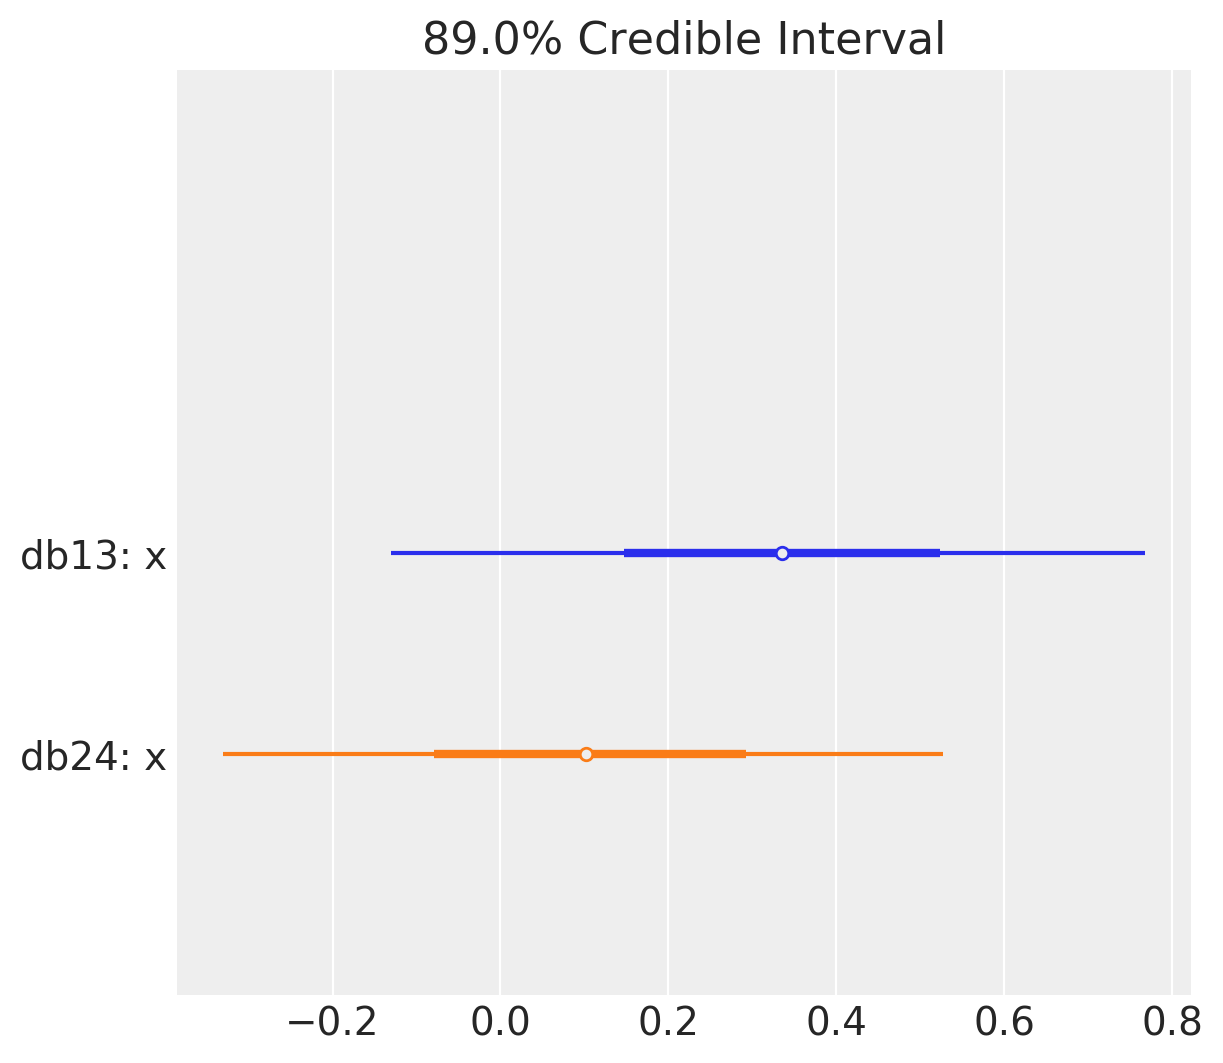

In [36]:
db13 = idata_11_4.posterior["b"].sel(b_dim_0 = 0) - idata_11_4.posterior["b"].sel(b_dim_0 = 2)
db24 = idata_11_4.posterior["b"].sel(b_dim_0 = 1) - idata_11_4.posterior["b"].sel(b_dim_0 = 3)
az.plot_forest([db13.values, db24.values], model_names=["db13", "db24"], combined=True);

#### Code 11.15

In [37]:
pl = d.groupby(['actor', 'treatment']).agg('mean')['pulled_left'].unstack()
pl

treatment,0,1,2,3
actor,,,,
0,0.333333,0.500000,0.277778,0.555556
1,1.000000,1.000000,1.000000,1.000000
2,0.277778,0.611111,0.166667,0.333333
3,0.333333,0.500000,0.111111,0.444444
4,0.333333,0.555556,0.277778,0.500000
5,0.777778,0.611111,0.555556,0.611111
6,0.777778,0.833333,0.944444,1.000000


#### Code 11.16 and 11.17

In [38]:
with m11_4:
    pm.set_data({"actor_id": np.repeat(range(7), 4), "treat_id": list(range(4)) * 7})
    p_post = pm.sample_posterior_predictive(trace_11_4, random_seed=RANDOM_SEED, var_names=["p"])["p"]
p_mu = p_post.mean(0).reshape((7, 4))

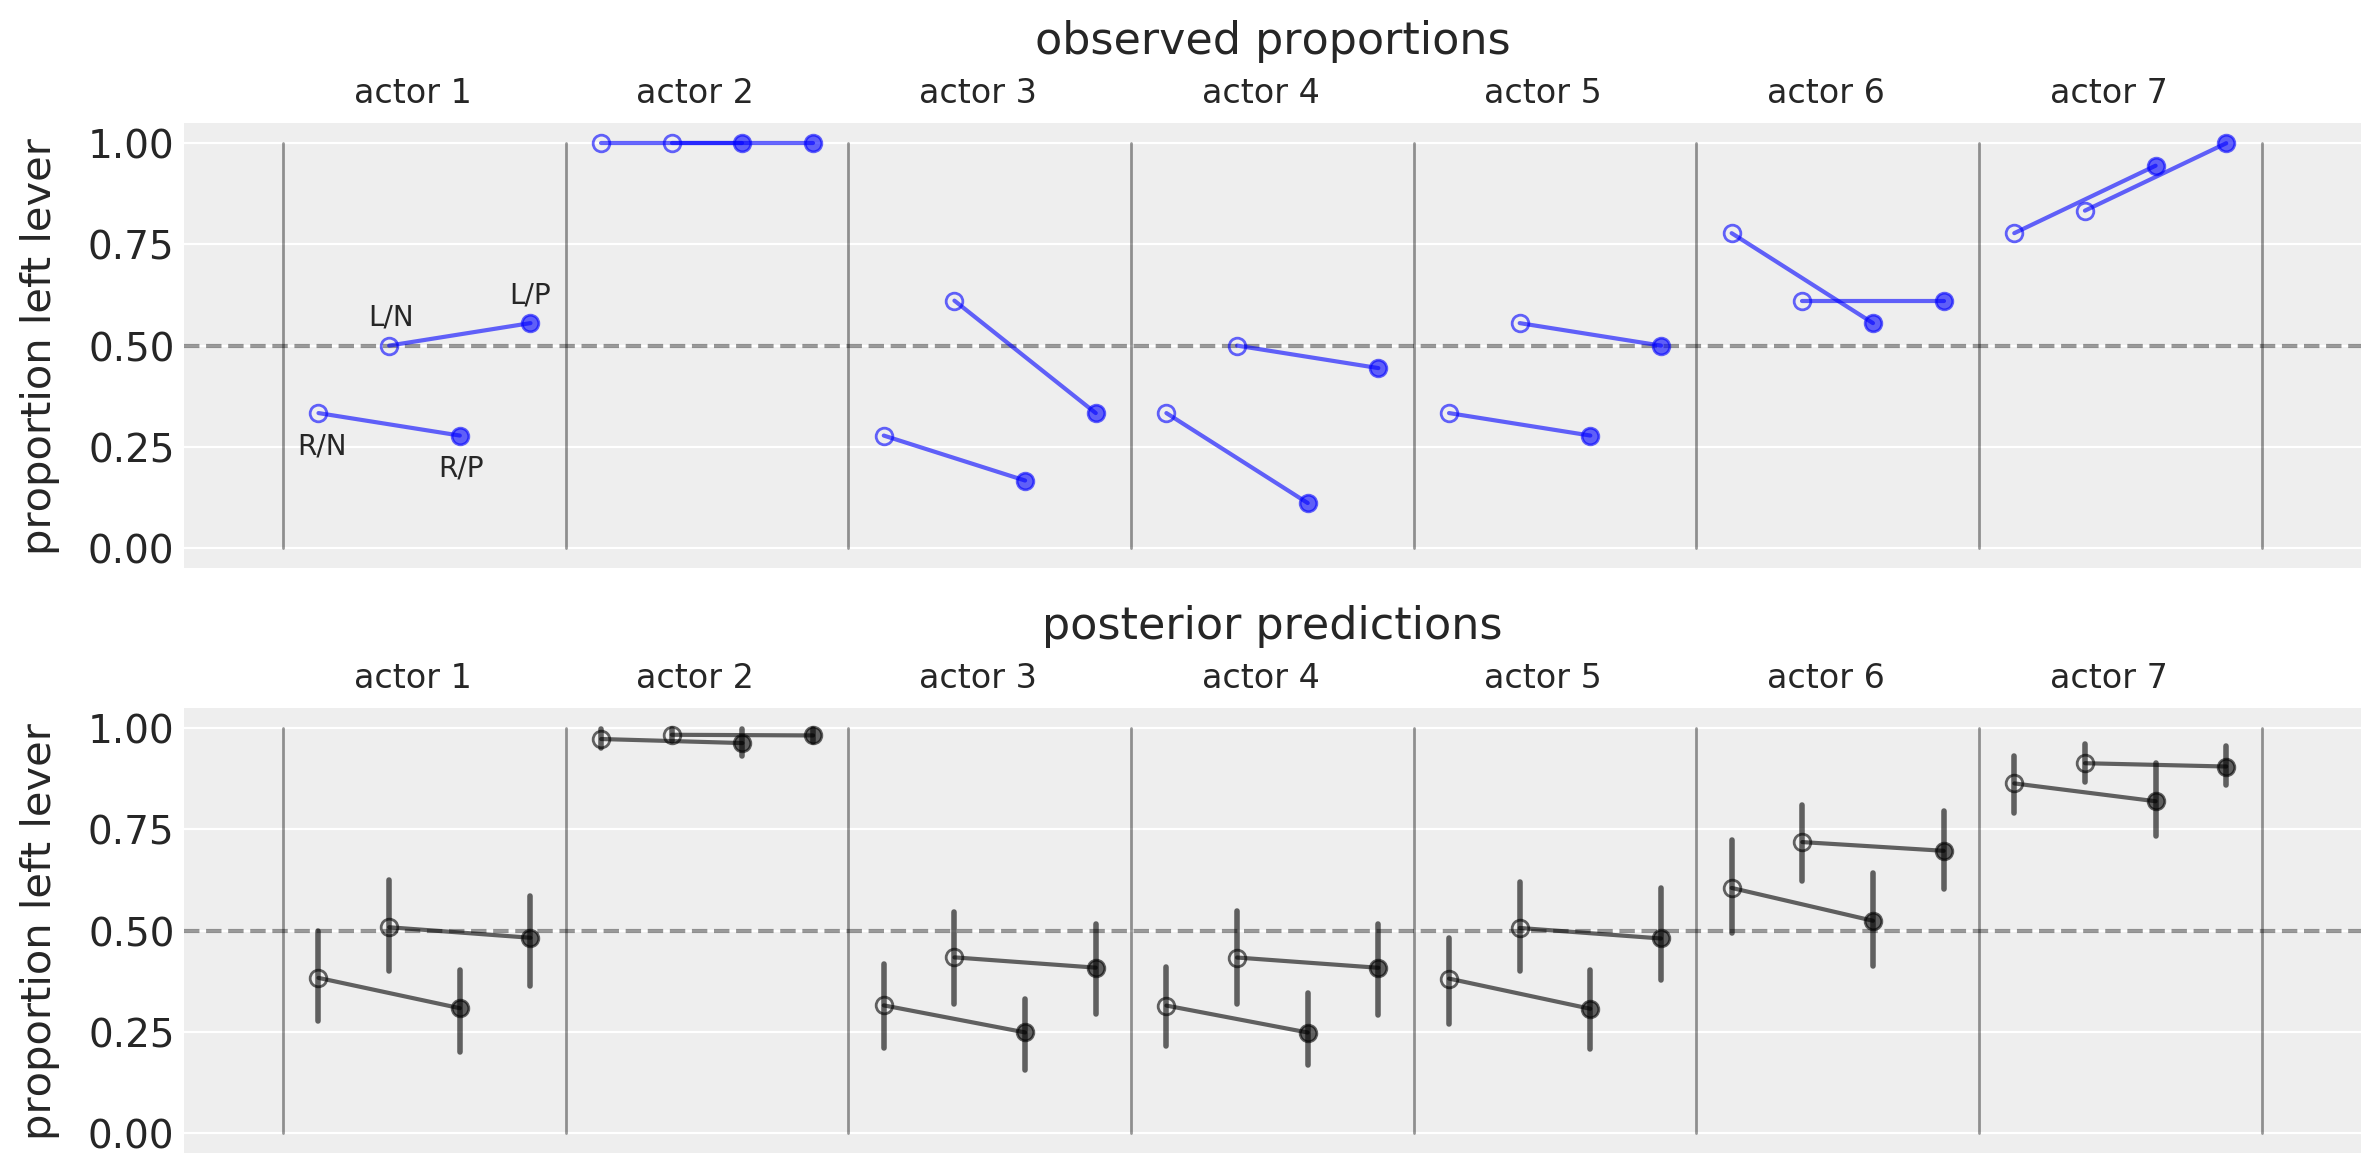

In [39]:
pl_val = pl.stack().values
_, (ax0, ax1) = plt.subplots(2, 1, figsize=(12, 6))
alpha, xoff, yoff = 0.6, 0.3, 0.05

ax0.plot([7 * 4 - 0.5] * 2, [0, 1], c="k", alpha=0.4, lw=1)
ax0.axhline(0.5, ls="--", c="k", alpha=0.4)
for actor in range(len(actors)):
    ax0.plot([actor * 4, actor * 4 + 2], [pl.loc[actor, 0], pl.loc[actor, 2]], "-",  c="b", alpha=alpha)
    ax0.plot([actor * 4 + 1, actor * 4 + 3], [pl.loc[actor, 1], pl.loc[actor, 3]], "-", c="b", alpha=alpha)
    ax0.plot([actor * 4, actor * 4 + 1], [pl.loc[actor, 0], pl.loc[actor, 1]], "o", c="b", fillstyle="none", ms=6, alpha=alpha)
    ax0.plot([actor * 4 + 2, actor * 4 + 3], [pl.loc[actor, 2], pl.loc[actor, 3]], "o", c="b", ms=6, alpha=alpha)
    ax0.plot([actor * 4 - 0.5] * 2, [0, 1], c="k", alpha=0.4, lw=1)
    ax0.text(actor * 4 + 0.5, 1.1, f"actor {actor + 1}", fontsize=12)
    if actor == 0:
        ax0.text(actor * 4 - xoff, pl.loc[actor, 0] - 2 * yoff, "R/N")
        ax0.text(actor * 4 + 1 - xoff, pl.loc[actor, 1] + yoff, "L/N")
        ax0.text(actor * 4 + 2 - xoff, pl.loc[actor, 2] - 2 * yoff, "R/P")
        ax0.text(actor * 4 + 3 - xoff, pl.loc[actor, 3] + yoff, "L/P")
ax0.set_xticks([])
ax0.set_ylabel("proportion left lever", labelpad=10)
ax0.set_title("observed proportions", pad=25)

ax1.plot([range(28), range(28)], az.hpd(p_post).T, "k-", lw=2, alpha=alpha)
ax1.plot([7 * 4 - 0.5] * 2, [0, 1], c="k", alpha=0.4, lw=1)
ax1.axhline(0.5, ls="--", c="k", alpha=0.4)
for actor in range(len(actors)):
    ax1.plot([actor * 4, actor * 4 + 2], [p_mu[actor, 0], p_mu[actor, 2]], "-",  c="k", alpha=alpha)
    ax1.plot([actor * 4 + 1, actor * 4 + 3], [p_mu[actor, 1], p_mu[actor, 3]], "-", c="k", alpha=alpha)
    ax1.plot([actor * 4, actor * 4 + 1], [p_mu[actor, 0], p_mu[actor, 1]], "o", c="k", fillstyle="none", ms=6, alpha=alpha)
    ax1.plot([actor * 4 + 2, actor * 4 + 3], [p_mu[actor, 2], p_mu[actor, 3]], "o", c="k", ms=6, alpha=alpha)
    ax1.plot([actor * 4 - 0.5] * 2, [0, 1], c="k", alpha=0.4, lw=1)
    ax1.text(actor * 4 + 0.5, 1.1, f"actor {actor + 1}", fontsize=12)
ax1.set_xticks([])
ax1.set_ylabel("proportion left lever", labelpad=10)
ax1.set_title("posterior predictions", pad=25)
plt.tight_layout();

#### Code 11.18

In [40]:
side = d.prosoc_left.values # right 0, left 1
cond = d.condition.values # no partner 0, partner 1

#### Code 11.19

In [41]:
with pm.Model() as m11_5:
    a = pm.Normal('a', 0., 1.5, shape=len(actors))
    bs = pm.Normal('bs', 0., 0.5, shape=2)
    bc = pm.Normal('bc', 0., 0.5, shape=2)
    
    p = pm.math.invlogit(a[actor_idx] + bs[side] + bc[cond])
    
    pulled_left = pm.Binomial('pulled_left', 1, p, observed=d.pulled_left)

    trace_11_5 = pm.sample(tune=1000, random_seed=RANDOM_SEED)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [bc, bs, a]


#### Code 11.20
As we changed the data of `m11_4` above, we need to sample from it again, with the original data:

In [42]:
with m11_4:
    pm.set_data({"actor_id": actor_idx, "treat_id": treat_idx})
    trace_11_4 = pm.sample(tune=1000, random_seed=RANDOM_SEED)

az.compare({"m11_4": trace_11_4, "m11_5": trace_11_5})

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, a]


,rank,loo,p_loo,d_loo,weight,se,dse,warning,loo_scale
m11_5,0,-265.436,7.82865,0,0.657098,9.45788,0,False,log
m11_4,1,-266.12,8.44339,0.683919,0.342902,9.58536,0.655022,False,log


#### Code 11.23

In [43]:
np.exp(trace_11_4["b"][:, 3] - trace_11_4["b"][:, 1]).mean().round(3)

0.933

#### Code 11.24

In [44]:
d_aggregated = d.groupby(["treatment", "actor"]).sum().reset_index()[["treatment", "actor", "pulled_left"]]
d_aggregated.head(10)

,treatment,actor,pulled_left
0,0,0,6
1,0,1,18
2,0,2,5
3,0,3,6
4,0,4,6
5,0,5,14
6,0,6,14
7,1,0,9
8,1,1,18
9,1,2,11


#### Code 11.25

In [45]:
with pm.Model() as m11_6:
    a = pm.Normal('a', 0., 1.5, shape=len(actors))
    b = pm.Normal('b', 0., 0.5, shape=len(treatments))
    
    p = pm.Deterministic("p", pm.math.invlogit(a[d_aggregated.actor] + b[d_aggregated.treatment]))
    
    pulled_left = pm.Binomial('pulled_left', 18, p, observed=d_aggregated.pulled_left)

    trace_11_6 = pm.sample(tune=1000, random_seed=RANDOM_SEED)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, a]


#### Code 11.26
ArviZ won't even let you compare models with different observations:

In [46]:
az.compare({"m11_4": trace_11_4, "m11_6": trace_11_6})

/Users/alex_andorra/opt/anaconda3/envs/stat-rethink-pymc3/lib/python3.7/site-packages/arviz/stats/stats.py:532: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  "Estimated shape parameter of Pareto distribution is greater than 0.7 for "


ValueError: The number of observations should be the same across all models

#### Code 11.27

In [47]:
# deviance of aggregated 6-in-9 
(-2 * stats.binom.logpmf(6, 9, 0.2)).round(5)

11.79048

In [48]:
# deviance of dis-aggregated 
-2 * stats.bernoulli.logpmf([1,1,1,1,1,1,0,0,0], 0.2).sum().round(5)

20.65212

#### Code 11.28

In [49]:
d_ad = pd.read_csv('Data/UCBadmit.csv', sep=';')
d_ad

,dept,applicant.gender,admit,reject,applications
1,A,male,512,313,825
2,A,female,89,19,108
3,B,male,353,207,560
4,B,female,17,8,25
5,C,male,120,205,325
6,C,female,202,391,593
7,D,male,138,279,417
8,D,female,131,244,375
9,E,male,53,138,191
10,E,female,94,299,393


#### Code 11.29

In [50]:
gid = (d_ad['applicant.gender'] == 'female').astype(int).values
    
with pm.Model() as m11_7:
    a = pm.Normal('a', 0, 1.5, shape=2)
    p = pm.Deterministic("p", pm.math.invlogit(a[gid]))
    
    admit = pm.Binomial('admit', p=p, n=d_ad.applications, observed=d_ad.admit)
    
    trace_11_7 = pm.sample(tune=1000, random_seed=RANDOM_SEED)
az.summary(trace_11_7, var_names=["a"], round_to=2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a]


,mean,sd,hpd_5.5%,hpd_94.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
a[0],-0.22,0.04,-0.28,-0.16,0.0,0.0,1521.56,1521.56,1535.13,1297.72,1.0
a[1],-0.83,0.05,-0.91,-0.75,0.0,0.0,1943.13,1937.38,1934.72,1492.93,1.0


#### Code 11.30

In [51]:
diff_a = trace_11_7["a"][:, 0] - trace_11_7["a"][:, 1]
diff_p = logistic(trace_11_7["a"][:, 0]) - logistic(trace_11_7["a"][:, 1])
az.summary({"diff_a": diff_a, "diff_p": diff_p}, kind="stats", round_to=2)

,mean,sd,hpd_5.5%,hpd_94.5%
diff_a,0.61,0.07,0.51,0.72
diff_p,0.14,0.01,0.12,0.17


#### Code 11.31

In [52]:
with m11_7:
    ppc = pm.sample_posterior_predictive(trace_11_7, random_seed=RANDOM_SEED, var_names=["admit"])["admit"]
pp_admit = ppc / d_ad.applications.values[None, :]

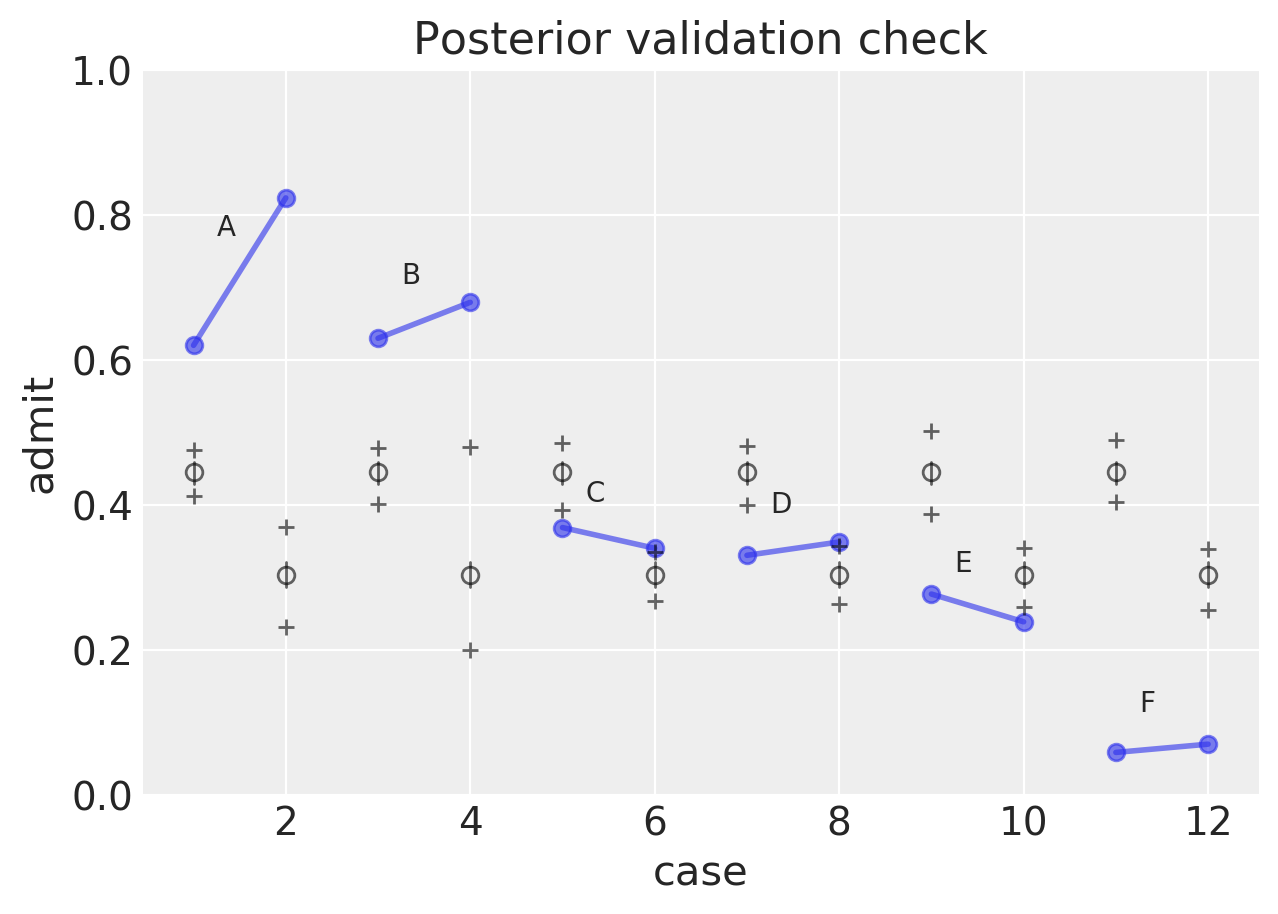

In [53]:
for i in range(6):
    x = 1 + 2 * i
    
    y1 = d_ad.admit[x] / d_ad.applications[x]
    y2 = d_ad.admit[x+1] / d_ad.applications[x+1]

    plt.plot([x, x+1], [y1, y2], '-C0o', alpha=0.6, lw=2)
    plt.text(x + 0.25, (y1+y2)/2 + 0.05, d_ad.dept[x])

plt.plot(range(1, 13), trace_11_7["p"].mean(0), "ko", fillstyle="none", ms=6, alpha=0.6)
plt.plot([range(1, 13), range(1, 13)], az.hpd(trace_11_7["p"]).T, "k-", lw=1, alpha=0.6)
plt.plot([range(1, 13), range(1, 13)], az.hpd(pp_admit).T, "k+", ms=6, alpha=0.6)

plt.xlabel("case")
plt.ylabel("admit")
plt.title("Posterior validation check")
plt.ylim(0, 1);

#### Code 11.32

In [54]:
dept_id = pd.Categorical(d_ad['dept']).codes

with pm.Model() as m11_8:
    a = pm.Normal('a', 0, 1.5, shape=2)
    delta = pm.Normal('delta', 0, 1.5, shape=6)
    
    p = pm.math.invlogit(a[gid] + delta[dept_id])
    
    admit = pm.Binomial('admit', p=p, n=d_ad.applications, observed=d_ad.admit)
    
    trace_11_8 = pm.sample(2000, tune=1000, random_seed=RANDOM_SEED)
az.summary(trace_11_8, round_to=2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [delta, a]


The number of effective samples is smaller than 10% for some parameters.


,mean,sd,hpd_5.5%,hpd_94.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
a[0],-0.52,0.56,-1.37,0.43,0.02,0.01,711.36,711.36,718.05,616.07,1.0
a[1],-0.42,0.57,-1.27,0.52,0.02,0.02,711.63,698.21,718.27,590.41,1.0
delta[0],1.10,0.57,0.22,2.03,0.02,0.01,713.67,713.67,720.04,640.26,1.0
delta[1],1.05,0.57,0.15,1.96,0.02,0.01,726.81,726.81,733.39,593.29,1.0
delta[2],-0.16,0.57,-1.10,0.71,0.02,0.02,714.16,459.55,721.01,595.16,1.0
delta[3],-0.20,0.57,-1.11,0.69,0.02,0.02,710.88,455.28,716.07,644.38,1.0
delta[4],-0.64,0.57,-1.53,0.29,0.02,0.02,724.36,538.16,730.41,630.04,1.0
delta[5],-2.20,0.58,-3.12,-1.29,0.02,0.02,747.32,694.73,753.37,691.83,1.0


#### Code 11.33

In [55]:
diff_a = trace_11_8["a"][:, 0] - trace_11_8["a"][:, 1]
diff_p = logistic(trace_11_8["a"][:, 0]) - logistic(trace_11_8["a"][:, 1])
az.summary({"diff_a": diff_a, "diff_p": diff_p}, kind="stats", round_to=2)

,mean,sd,hpd_5.5%,hpd_94.5%
diff_a,-0.10,0.08,-0.22,0.03
diff_p,-0.02,0.02,-0.05,0.01


#### Code 11.34

In [56]:
pg = pd.DataFrame(index=["male", "female"], columns=d_ad.dept.unique())
for dep in pg.columns:
    pg[dep] = (d_ad.loc[d_ad.dept == dep, "applications"] / d_ad.loc[d_ad.dept == dep, "applications"].sum()).values
pg.round(2)

,A,B,C,D,E,F
male,0.88,0.96,0.35,0.53,0.33,0.52
female,0.12,0.04,0.65,0.47,0.67,0.48


#### Code 11.35

In [57]:
y = np.random.binomial(n=1000, p=1/1000, size=10_000) 
y.mean(), y.var()

(1.0022, 1.0089951599999998)

#### Code 11.36

In [3]:
dk = pd.read_csv('Data/Kline', sep=';')
dk

,culture,population,contact,total_tools,mean_TU
0,Malekula,1100,low,13,3.2
1,Tikopia,1500,low,22,4.7
2,Santa Cruz,3600,low,24,4.0
3,Yap,4791,high,43,5.0
4,Lau Fiji,7400,high,33,5.0
5,Trobriand,8000,high,19,4.0
6,Chuuk,9200,high,40,3.8
7,Manus,13000,low,28,6.6
8,Tonga,17500,high,55,5.4
9,Hawaii,275000,low,71,6.6


#### Code 11.37

In [4]:
P = standardize(np.log(dk.population)).values
c_id = (dk.contact == "high").astype(int).values

#### Code 11.38

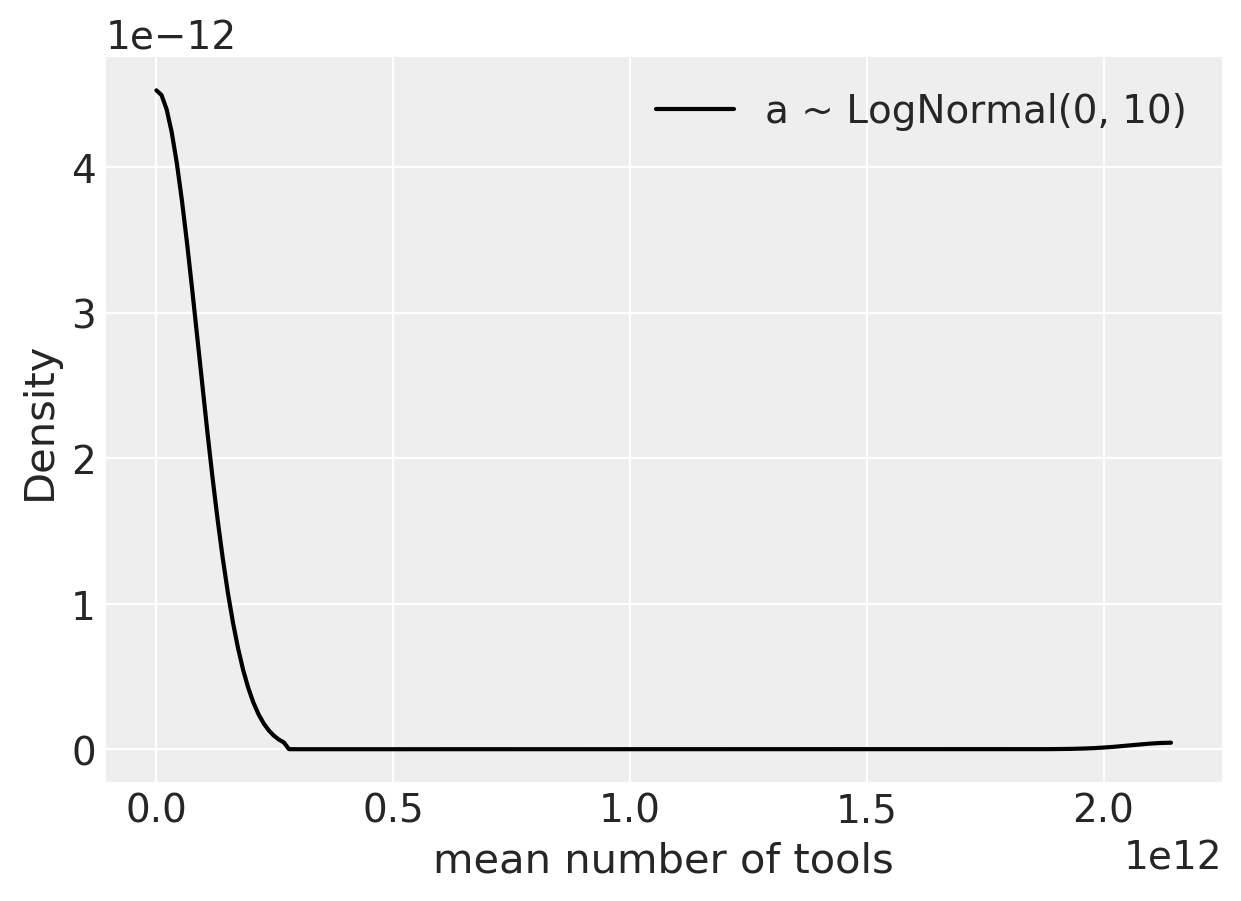

In [5]:
ax = az.plot_kde(pm.Lognormal.dist(0., 10.).random(size=200), label="a ~ LogNormal(0, 10)", plot_kwargs={"color": "k"})
ax.set_xlabel("mean number of tools")
ax.set_ylabel("Density")
ax.set_title("");

#### Code 11.39

In [6]:
a = np.random.normal(0., 10., size=10_000)
np.exp(a).mean()

5208551972312.05

#### Code 11.40

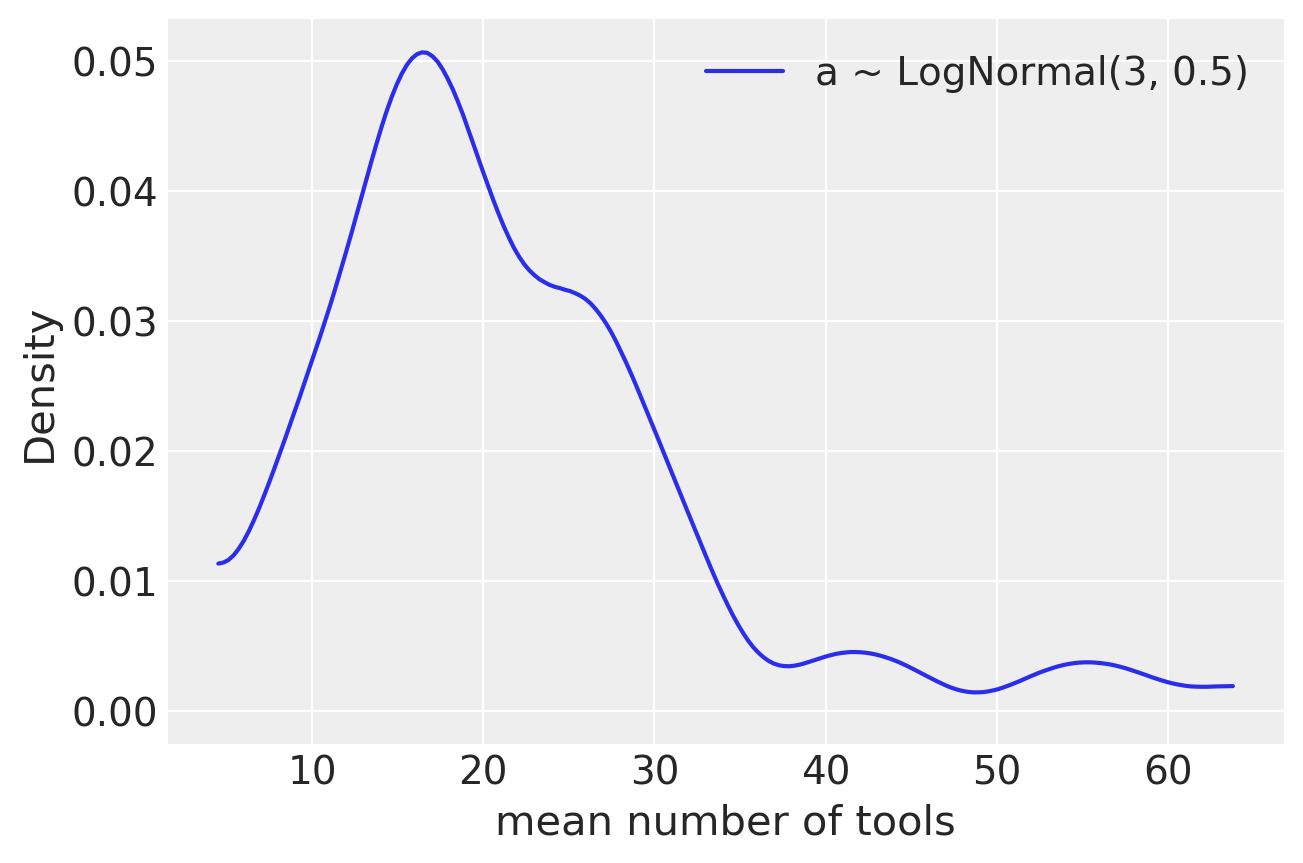

In [7]:
ax = az.plot_kde(pm.Lognormal.dist(3., 0.5).random(size=200), label="a ~ LogNormal(3, 0.5)")
ax.set_xlabel("mean number of tools")
ax.set_ylabel("Density")
ax.set_title("");

#### Code 11.41 to 11.44

In [8]:
def kline_prior_plot(N: int = 100, b_prior: str = "bespoke", x_scale: str = "stdz", ax=None):
    """
    Utility function to plot prior predictive checks for Kline Poisson model.
    N: number of prior predictive trends.
    
    """
    if ax is None:
        _, ax = plt.subplots()
    ax.set_ylabel("total tools")
    
    itcpts = np.random.normal(3., 0.5, N)
    if b_prior == "conventional":
        slopes = np.random.normal(0., 10., N)
        ax.set_title("b ~ Normal(0, 10)")
    elif b_prior == "bespoke":
        slopes = np.random.normal(0., 0.2, N)
        ax.set_title("b ~ Normal(0, 0.2)")
    else:
        raise ValueError("Prior for slopes (b_prior) can only be either 'conventional' or 'bespoke'.")
    
    x_seq = np.linspace(np.log(100), np.log(200_000), N)
    ax.set_ylim((0, 500))
    if x_scale == "log":
        for a, b in zip(itcpts, slopes):
            ax.plot(x_seq, np.exp(a + b * x_seq), "k", alpha=0.4)
        ax.set_xlabel("log population")
    elif x_scale == "natural":
        for a, b in zip(itcpts, slopes):
            ax.plot(np.exp(x_seq), np.exp(a + b * x_seq), "k", alpha=0.4)
        ax.set_xlabel("population")
    else:
        x_seq = np.linspace(-2, 2, N)
        for a, b in zip(itcpts, slopes):
            ax.plot(x_seq, np.exp(a + b * x_seq), "k", alpha=0.4)
        ax.set_ylim((0, 100))
        ax.set_xlabel("log population (std)")
    
    return ax

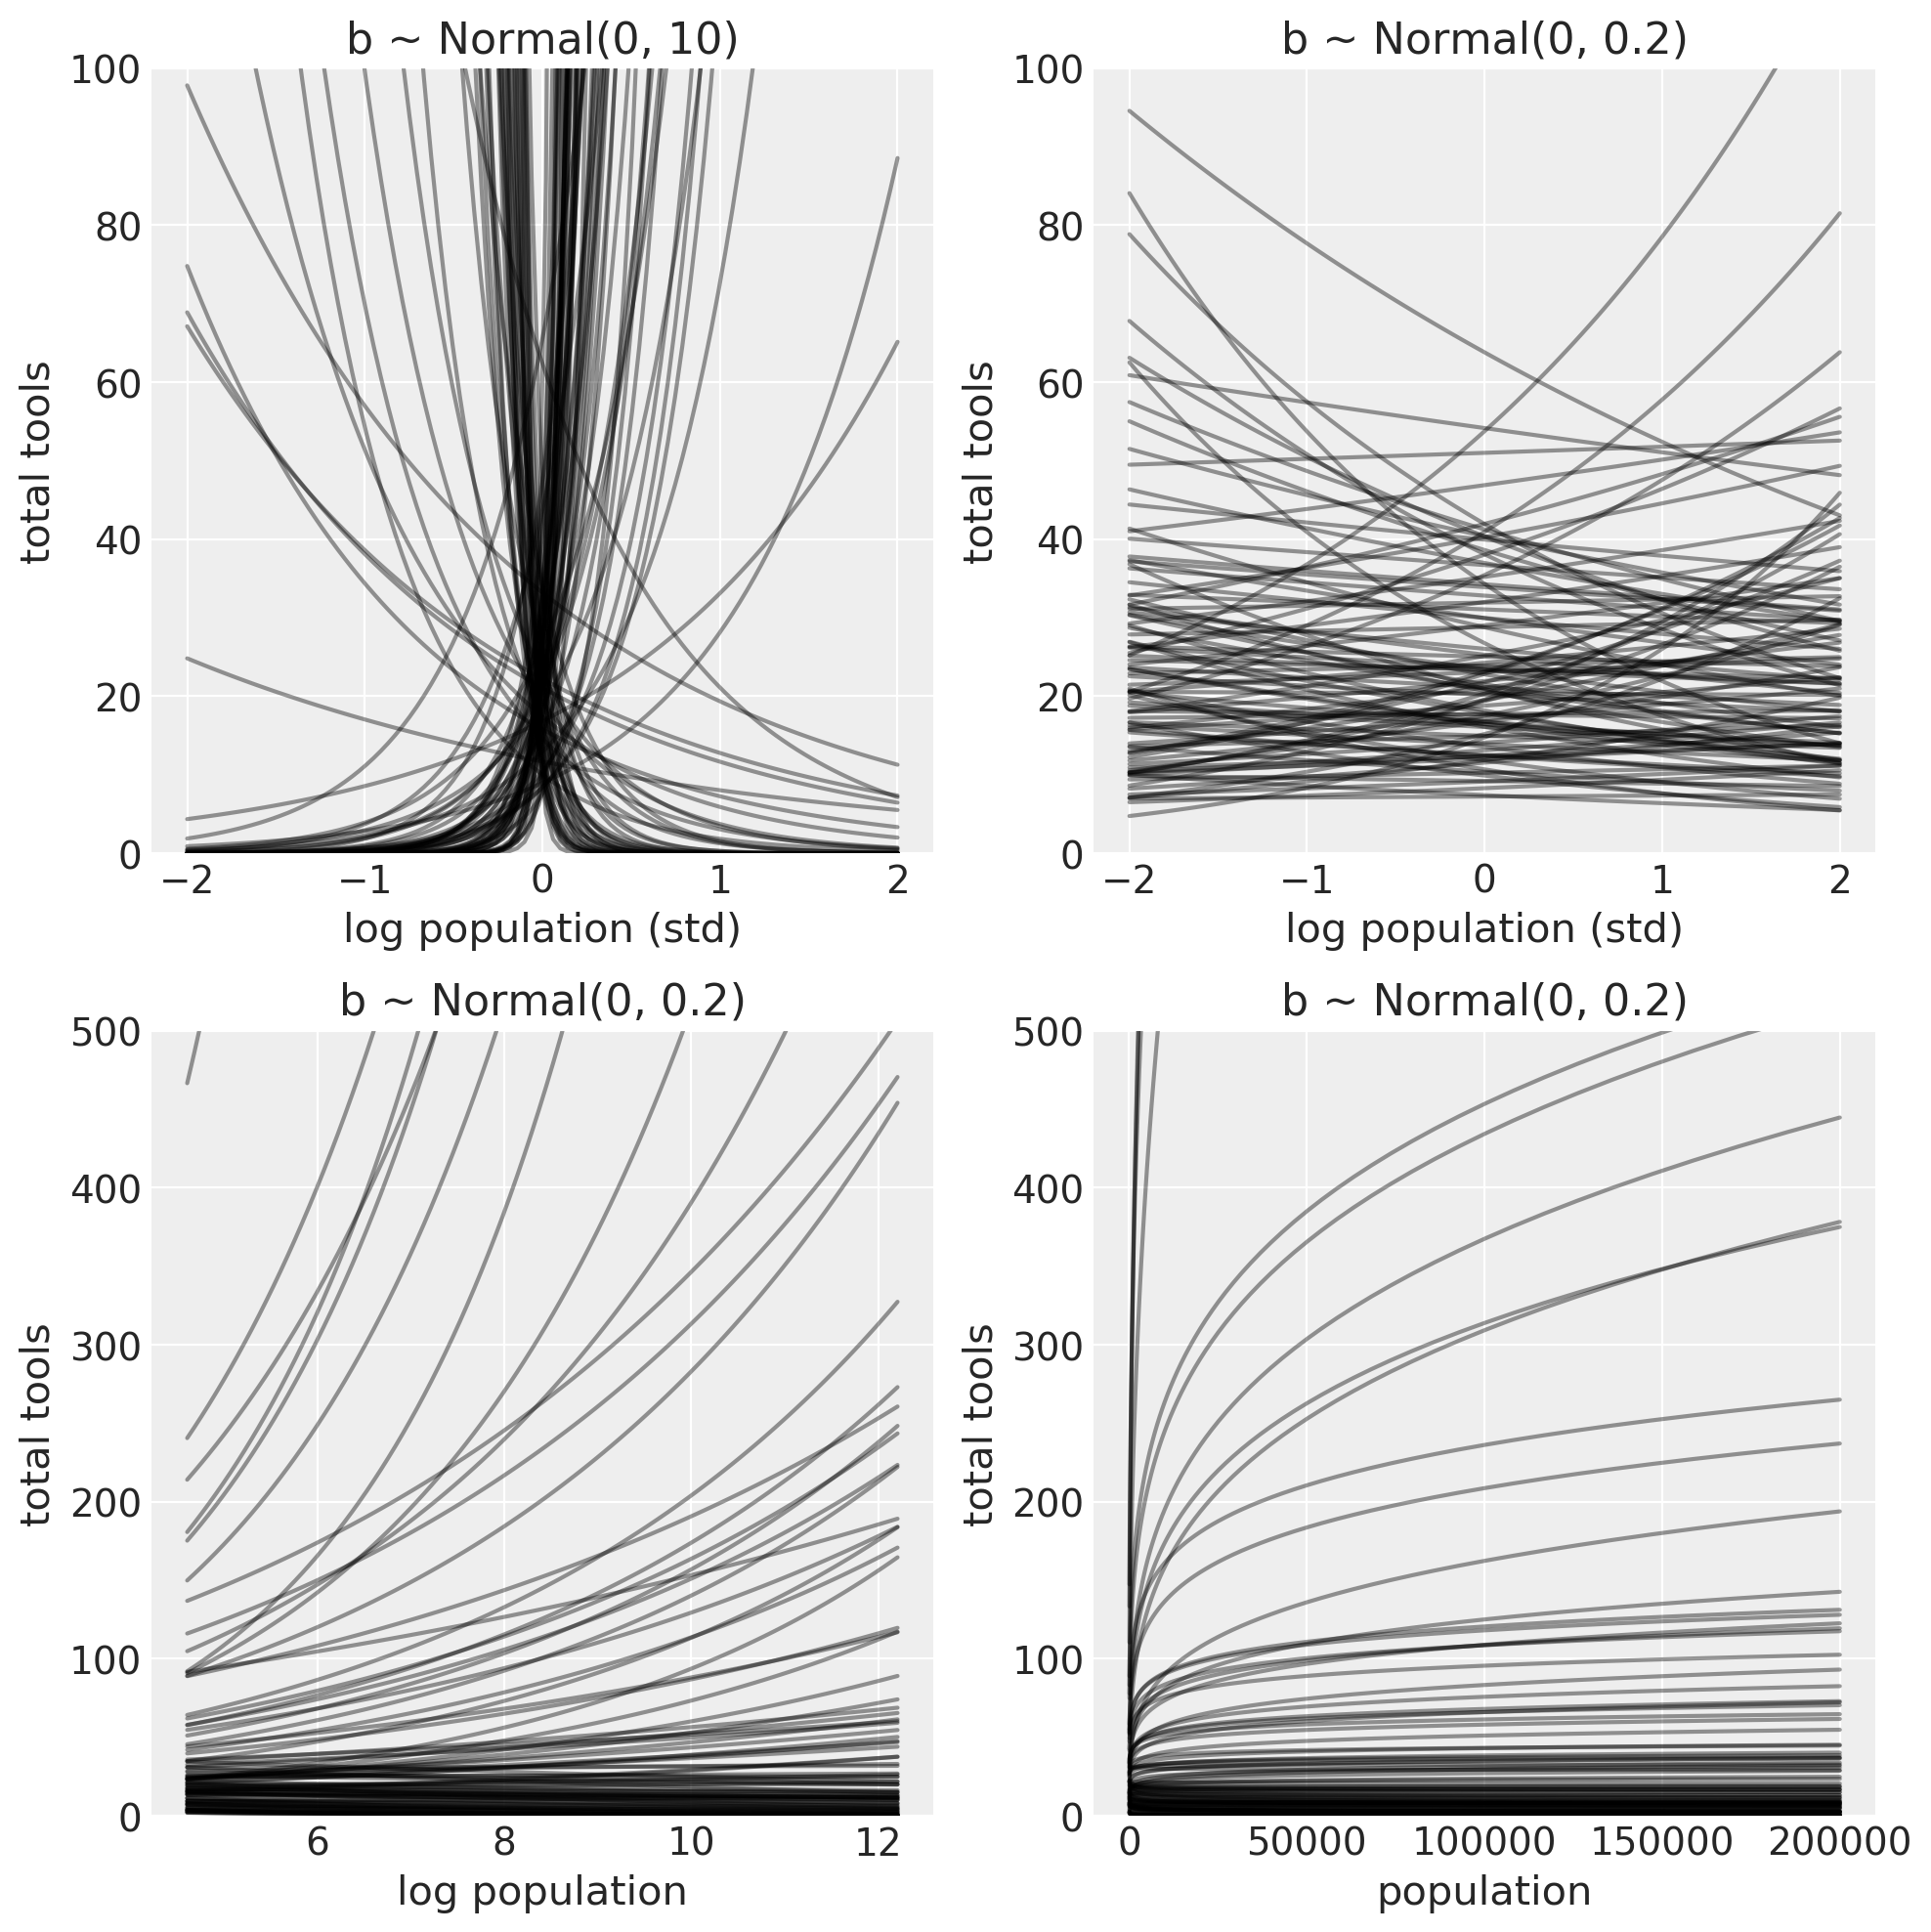

In [9]:
_, ax = plt.subplots(2, 2, figsize=(10, 10))
kline_prior_plot(b_prior="conventional", x_scale="stdz", ax=ax[0][0])
kline_prior_plot(b_prior="bespoke", x_scale="stdz", ax=ax[0][1])
kline_prior_plot(b_prior="bespoke", x_scale="log", ax=ax[1][0])
kline_prior_plot(x_scale="natural", ax=ax[1][1])
plt.tight_layout();

#### Code 11.45

In [10]:
# intercept only
with pm.Model() as m11_9:
    a = pm.Normal('a', 3., 0.5)
    T = pm.Poisson('total_tools', pm.math.exp(a), observed=dk.total_tools)
    trace_11_9 = pm.sample(1000, tune=2000, random_seed=RANDOM_SEED)

# interaction model
with pm.Model() as m11_10:
    a = pm.Normal('a', 3., 0.5, shape=2)
    b = pm.Normal('b', 0., 0.2, shape=2)
    
    cid = pm.intX(pm.Data("cid", c_id))
    P_ = pm.Data("P", standardize(np.log(dk.population)).values)
    lam = pm.math.exp(a[cid] + b[cid] * P_)
    
    T = pm.Poisson('total_tools', lam, observed=dk.total_tools)
    trace_11_10 = pm.sample(1000, tune=2000, random_seed=RANDOM_SEED)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, a]


#### Code 11.46

In [11]:
az.compare({"m11_9": trace_11_9, "m11_10": trace_11_10})
# store pareto-k values for plot:
k = az.loo(trace_11_10, pointwise=True).pareto_k.values

/Users/alex_andorra/opt/anaconda3/envs/stat-rethink-pymc3/lib/python3.7/site-packages/arviz/stats/stats.py:532: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  "Estimated shape parameter of Pareto distribution is greater than 0.7 for "
/Users/alex_andorra/opt/anaconda3/envs/stat-rethink-pymc3/lib/python3.7/site-packages/arviz/stats/stats.py:532: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-ro

#### Code 11.47 and 11.48

In [12]:
ns = 100
P_seq = np.linspace(-1.4, 3., ns)

with m11_10:
    # predictions for cid=0 (low contact)
    pm.set_data({"cid": np.array([0]*ns), "P": P_seq})
    lam0 = pm.sample_posterior_predictive(trace_11_10, var_names=["total_tools"])["total_tools"]
    
    # predictions for cid=1 (high contact)
    pm.set_data({"cid": np.array([1]*ns)})
    lam1 = pm.sample_posterior_predictive(trace_11_10, var_names=["total_tools"])["total_tools"]

lmu0, lmu1 = lam0.mean(0), lam1.mean(0)

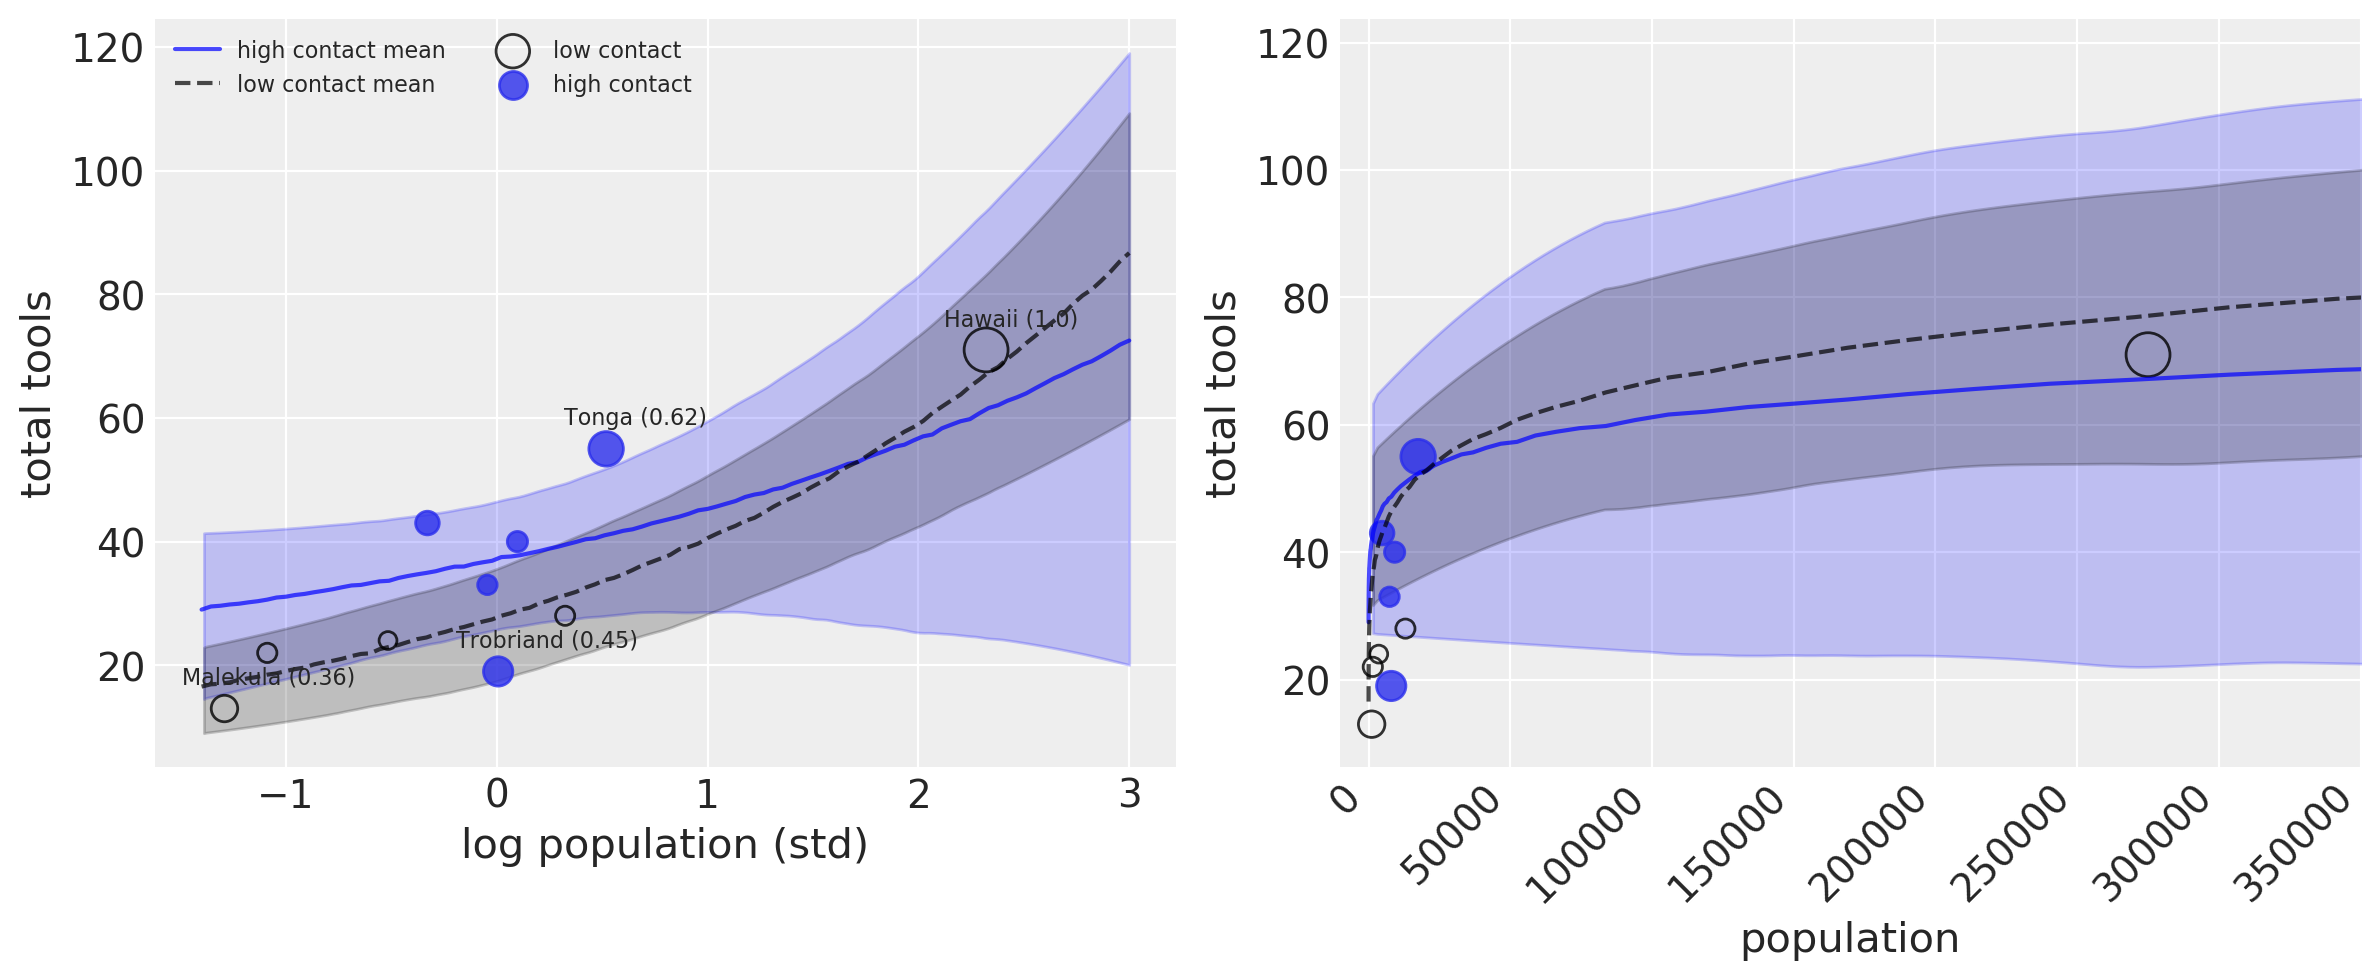

In [13]:
_, (ax0, ax1) = plt.subplots(1, 2, figsize=(12, 5))

# scale point size to Pareto-k:
k /= k.max()
psize = 250 * k

# Plot on standardized log scale:

az.plot_hpd(P_seq, lam1, color='b', fill_kwargs={"alpha": 0.2}, ax=ax0)
ax0.plot(P_seq, lmu1, color='b', alpha=0.7, label="high contact mean")

az.plot_hpd(P_seq, lam0, color='k', fill_kwargs={"alpha": 0.2}, ax=ax0)
ax0.plot(P_seq, lmu0, '--', color='k', alpha=0.7, label="low contact mean")

# display names and k:
mask = k > 0.3
labels = dk.culture.values[mask]
for i, text in enumerate(labels):
    ax0.text(P[mask][i] - 0.2, dk.total_tools.values[mask][i] + 4, f"{text} ({np.round(k[mask][i], 2)})", fontsize=8)

# display observed data:
index = c_id == 1
ax0.scatter(P[~index], dk.total_tools[~index], s=psize[~index], facecolors='none', edgecolors='k', alpha=0.8, lw=1, label="low contact")
ax0.scatter(P[index], dk.total_tools[index], s=psize[index], alpha=0.8, label="high contact")
ax0.set_xlabel('log population (std)')
ax0.set_ylabel('total tools')
ax0.legend(fontsize=8, ncol=2)

# Plot on natural scale:
# unstandardize and exponentiate values of standardized log pop:
P_seq = np.linspace(-5., 3., ns)
P_seq = np.exp(P_seq * np.log(dk.population.values).std() + np.log(dk.population.values).mean())

az.plot_hpd(P_seq, lam1, color='b', fill_kwargs={"alpha": 0.2}, ax=ax1)
ax1.plot(P_seq, lmu1, color='b', alpha=0.7)

az.plot_hpd(P_seq, lam0, color='k', fill_kwargs={"alpha": 0.2}, ax=ax1)
ax1.plot(P_seq, lmu0, '--', color='k', alpha=0.7)

# display observed data:
ax1.scatter(dk.population[~index], dk.total_tools[~index], s=psize[~index], facecolors='none', edgecolors='k', alpha=0.8, lw=1)
ax1.scatter(dk.population[index], dk.total_tools[index], s=psize[index], alpha=0.8)
plt.setp(ax1.get_xticklabels(), ha="right", rotation=45)
ax1.set_xlim((-10_000, 350_000))
ax1.set_xlabel('population')
ax1.set_ylabel('total tools')
plt.tight_layout();

#### Code 11.49
The book doesn't pre-process the population data, but if you give them raw to PyMC3, the sampler will break: the scale of these data is too wide. However we can't just standardize the data, as we usually do. Why? Because some data points will then be negative, which doesn't play nice with the `b` exponent (try it if you don't trust me). But that's a good opportunity to use a new trick! We'll use scikit-learn's MinMaxScaler, which will ensure that our data stay positive -- specifically, we'll ask it to keep the data between 1 and 2:

In [55]:
scaler = MinMaxScaler(feature_range=(1, 2))
pop_scaled = np.squeeze(scaler.fit_transform(dk.population.values.reshape(-1, 1)))
pop_scaled

array([1.        , 1.00146039, 1.00912742, 1.01347572, 1.0230011 ,
       1.02519168, 1.02957284, 1.04344651, 1.05987587, 2.        ])

And now we can run the model:

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [g, b, a]


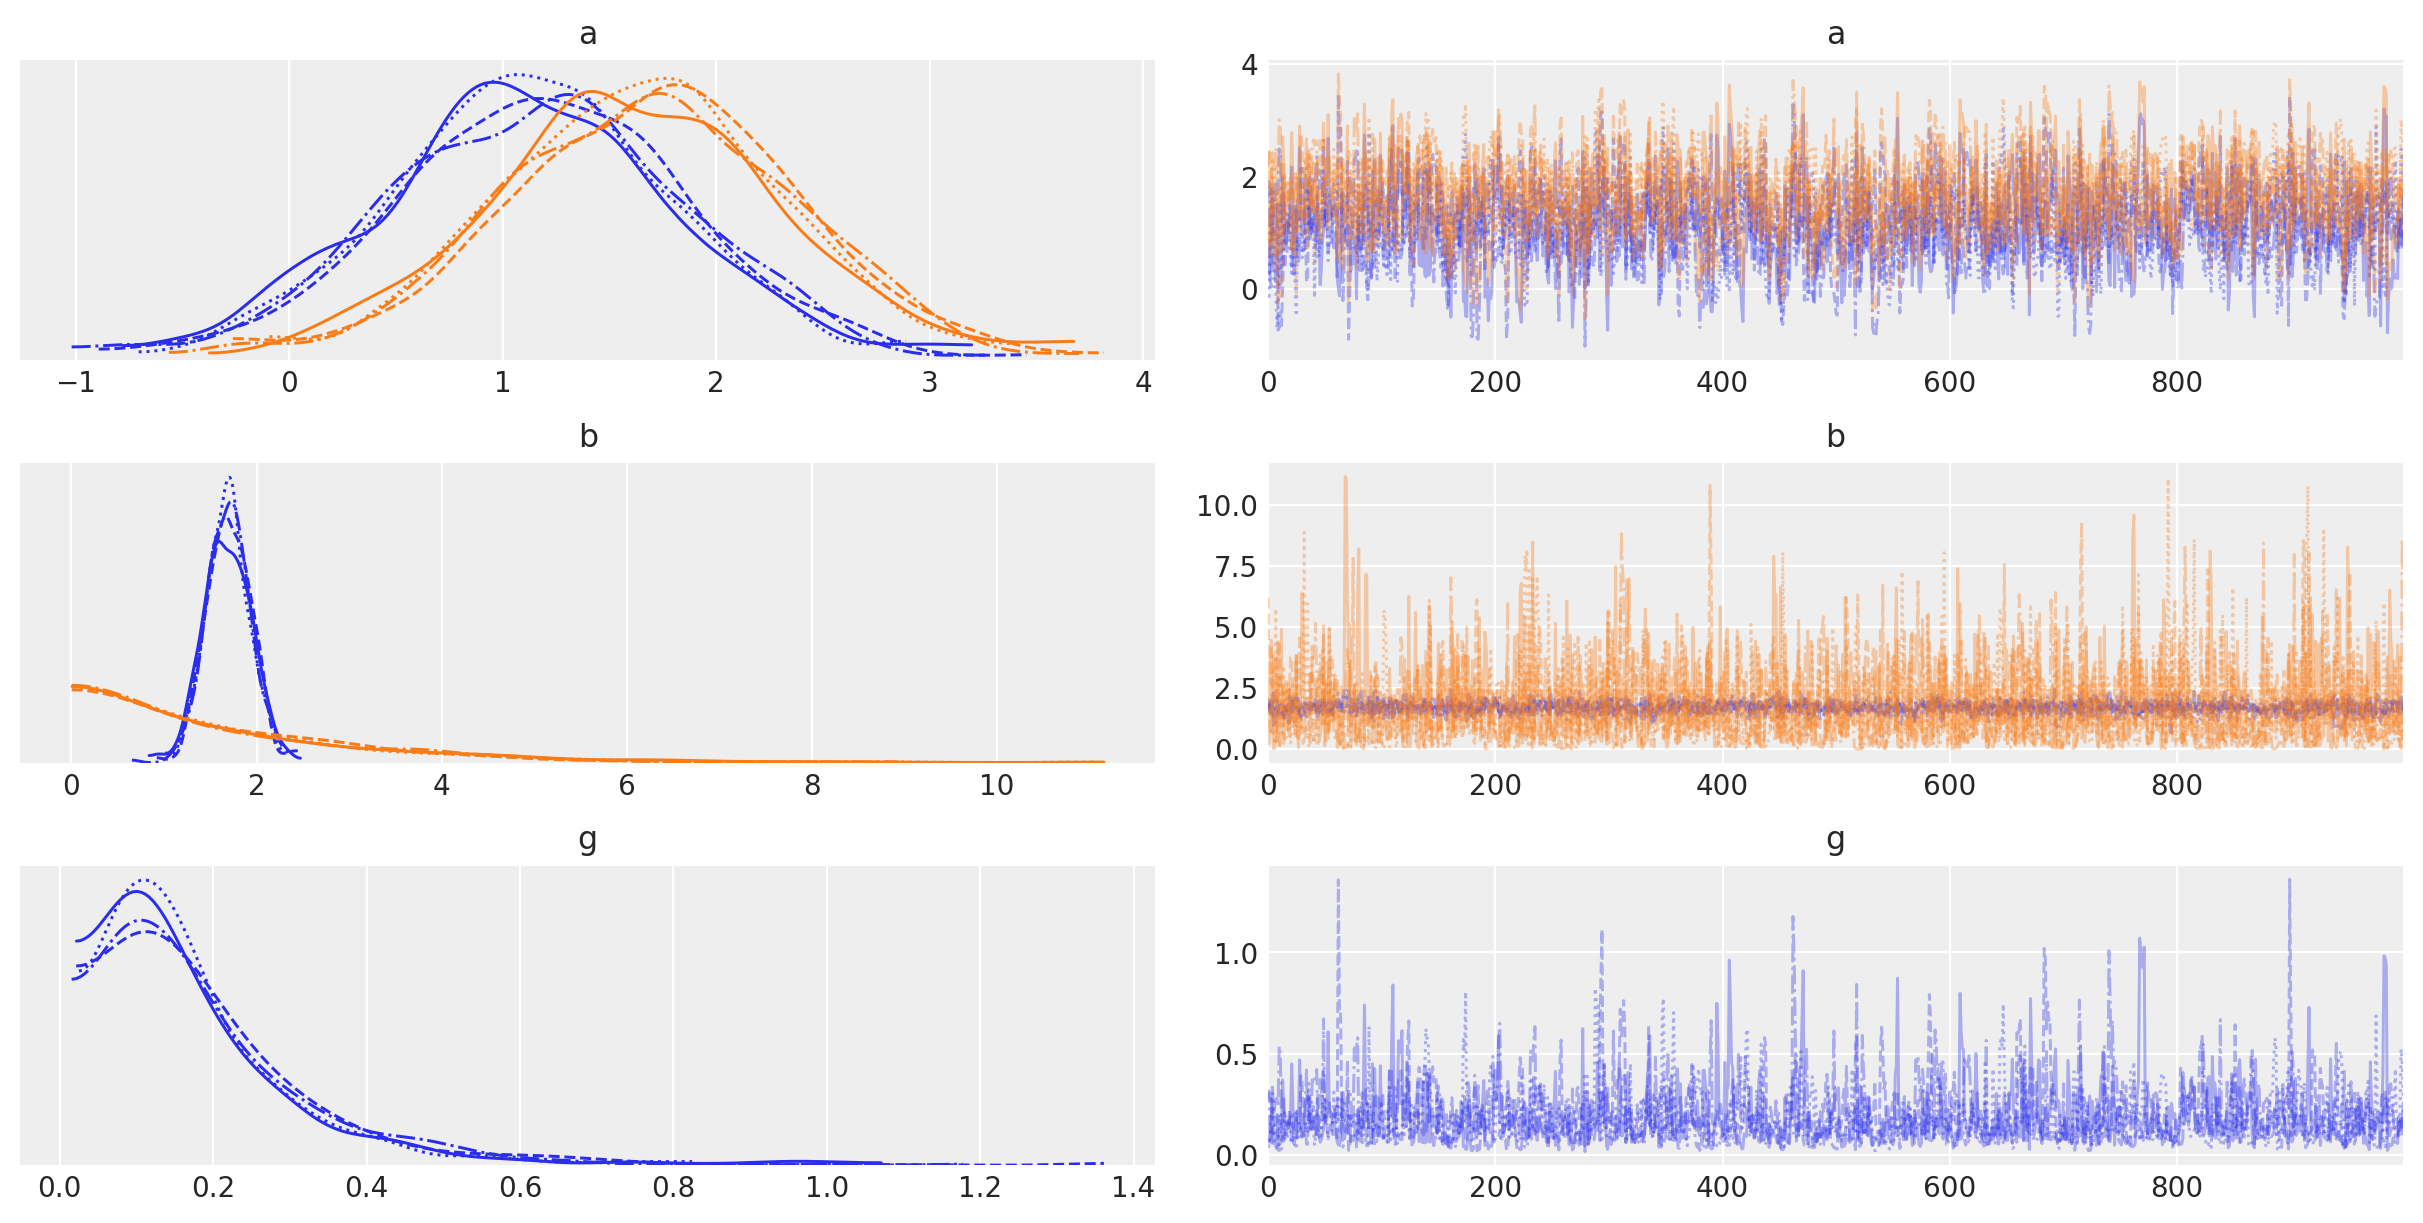

In [77]:
with pm.Model() as m11_11:
    a = pm.Normal('a', 1., 1., shape=2)
    b = pm.Exponential('b', 1., shape=2)
    g = pm.Exponential('g', 1.)
    
    cid = pm.intX(pm.Data("cid", c_id))
    pop_scaled_ = pm.Data("pop_scaled", pop_scaled)
    lam = (tt.exp(a[cid]) * pop_scaled_ ** b[cid]) / g
    
    T = pm.Poisson('total_tools', lam, observed=dk.total_tools)
    trace_11_11 = pm.sample(1000, tune=6000, random_seed=RANDOM_SEED)
az.plot_trace(trace_11_11, compact=True);

#### Bonus: posterior predictive plot for scientific model

In [78]:
ns = 100
P_seq = np.squeeze(scaler.transform(np.linspace(0., 350_000, ns).reshape(-1, 1)))
    
with m11_11:
    # predictions for cid=0 (low contact)
    pm.set_data({"cid": np.array([0]*ns), "pop_scaled": P_seq})
    lam0 = pm.sample_posterior_predictive(trace_11_11, var_names=["total_tools"])["total_tools"]
    
    # predictions for cid=1 (high contact)
    pm.set_data({"cid": np.array([1]*ns)})
    lam1 = pm.sample_posterior_predictive(trace_11_10, var_names=["total_tools"])["total_tools"]

lmu0, lmu1 = lam0.mean(0), lam1.mean(0)

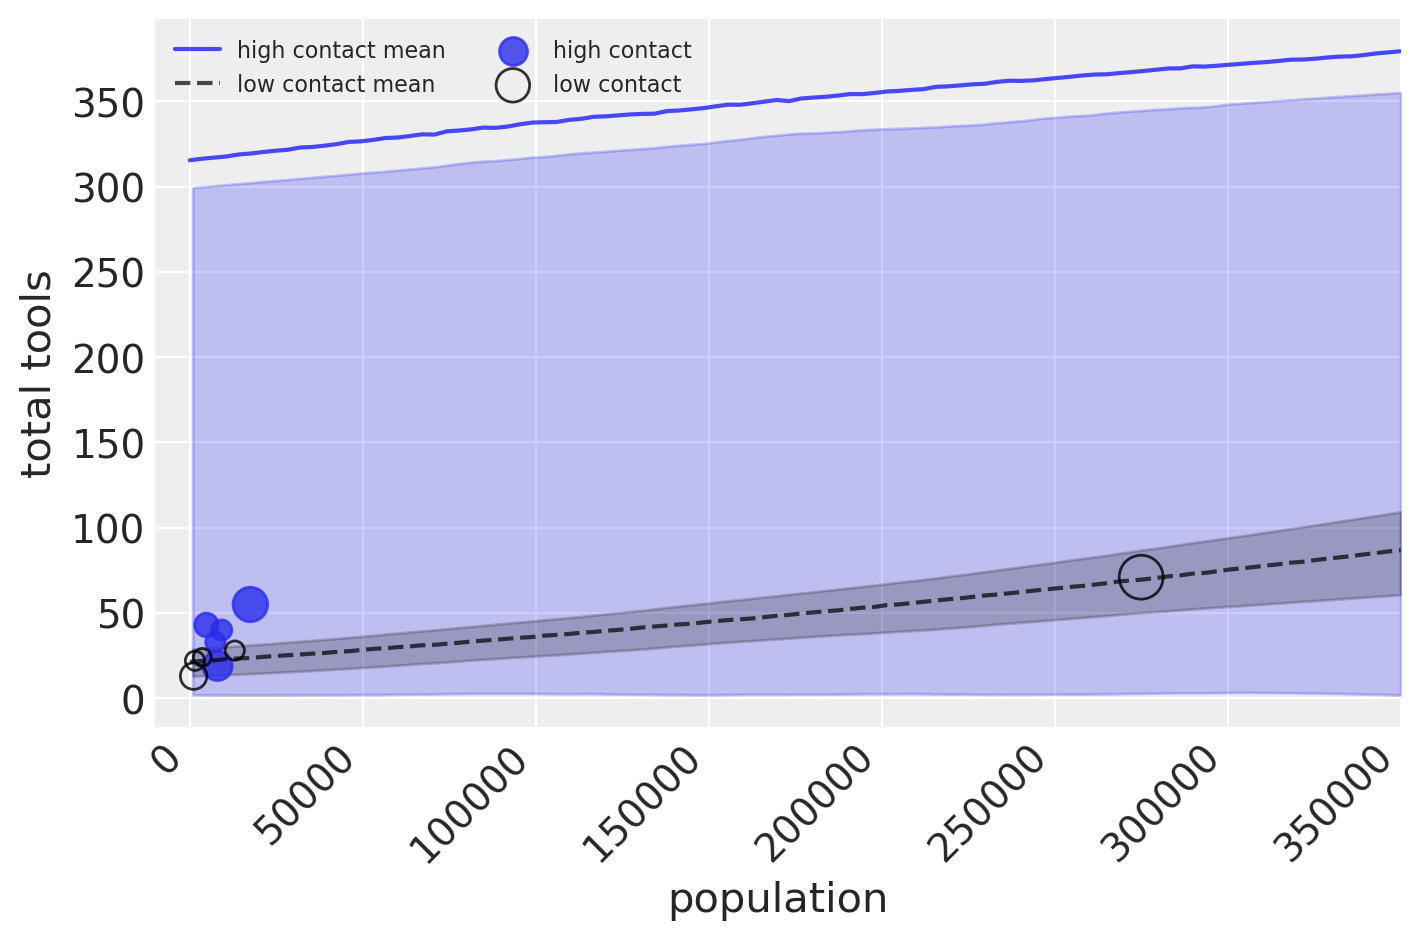

In [79]:
_, ax = plt.subplots(1, 1)

# un-scale population values:
P_seq = np.squeeze(scaler.inverse_transform(P_seq.reshape(-1, 1)))

az.plot_hpd(P_seq, lam1, color='b', fill_kwargs={"alpha": 0.2}, ax=ax)
ax.plot(P_seq, lmu1, color='b', alpha=0.7, label="high contact mean")

az.plot_hpd(P_seq, lam0, color='k', fill_kwargs={"alpha": 0.2}, ax=ax)
ax.plot(P_seq, lmu0, '--', color='k', alpha=0.7, label="low contact mean")

# display observed data:
ax.scatter(dk.population[index], dk.total_tools[index], s=psize[index], alpha=0.8, label="high contact")
ax.scatter(dk.population[~index], dk.total_tools[~index], s=psize[~index], facecolors='none', edgecolors='k', alpha=0.8, lw=1, label="low contact")

plt.setp(ax.get_xticklabels(), ha="right", rotation=45)
ax.set_xlim((-10_000, 350_000))
ax.set_xlabel('population')
ax.set_ylabel('total tools')
ax.legend(fontsize=8, ncol=2)
plt.tight_layout();

#### Code 11.50

In [7]:
num_days = 30
y = np.random.poisson(1.5, num_days)
y

array([1, 1, 1, 0, 1, 1, 0, 2, 1, 0, 1, 2, 3, 2, 2, 1, 0, 1, 0, 1, 1, 2,
       2, 2, 4, 1, 3, 3, 3, 3])

#### Code 11.51

In [8]:
num_weeks = 4
y_new = np.random.poisson(0.5*7, num_weeks)
y_new

array([2, 5, 3, 4])

#### Code 11.52

In [9]:
y_all = np.hstack([y, y_new])
exposure = np.hstack([np.repeat(1, 30), np.repeat(7, 4)]).astype('float')
monastery = np.hstack([np.repeat(0, 30), np.repeat(1, 4)])
y_all, exposure, monastery

(array([1, 1, 1, 0, 1, 1, 0, 2, 1, 0, 1, 2, 3, 2, 2, 1, 0, 1, 0, 1, 1, 2,
        2, 2, 4, 1, 3, 3, 3, 3, 2, 5, 3, 4]),
 array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 7., 7., 7., 7.]),
 array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1]))

#### Code 11.53

In [10]:
# compute the offset:
log_days = np.log(exposure)

# fit the model:
with pm.Model() as m11_12:
    a = pm.Normal('a', 0., 1.)
    b = pm.Normal('b', 0., 1.)
    
    lam = pm.math.exp(log_days + a + b*monastery)
    
    obs = pm.Poisson('y', lam, observed=y_all)
    
    trace_11_12 = pm.sample(1000, tune=2000, random_seed=RANDOM_SEED)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, a]


#### Code 11.54

In [11]:
lambda_old = np.exp(trace_11_12['a'])
lambda_new = np.exp(trace_11_12['a'] + trace_11_12['b'])

az.summary({"lambda_old": lambda_old, "lambda_new": lambda_new}, kind="stats", round_to=2)

,mean,sd,hpd_5.5%,hpd_94.5%
lambda_old,1.45,0.21,1.09,1.77
lambda_new,0.54,0.13,0.33,0.75


#### Code 11.55

In [97]:
# simulate career choices among 500 individuals
N = 500                 # number of individuals
income = np.array([1, 2, 5]) # expected income of each career
score = 0.5 * income      # score for each career, based on income
# converts scores to probabilities:
p = softmax(score)

# now simulate choice
# outcome career holds event type values, not counts
career = np.random.multinomial(1, p, size=N)
career = np.where(career==1)[1]
career[:11]

array([2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2])

#### Code 11.56 and 11.57

In [135]:
with pm.Model() as m11_13:
    a = pm.Normal('a', 0., 1., shape=2) # intercepts
    b = pm.Bound(pm.Normal, lower=0.)('b', mu=0., sigma=0.5) # association of income with choice
    # Bound (*James* Bound) is here to ensure b stays positive. Equivalent to 'real<lower=0> b' in the book.
    
    s0 = a[0] + b * income[0]
    s1 = a[1] + b * income[1]
    s2 = 0. # pivot
    s = pm.math.stack([s0, s1, s2])
    
    p_ = tt.nnet.softmax(s)
    career_obs = pm.Categorical('career', p=p_, observed=career)
    
    trace_11_13 = pm.sample(1000, tune=6000, target_accept=0.99, random_seed=RANDOM_SEED)
az.summary(trace_11_13, round_to=2)

/Users/alex_andorra/opt/anaconda3/envs/stat-rethink-pymc3/lib/python3.7/site-packages/ipykernel_launcher.py:11: UserWarning: DEPRECATION: If x is a vector, Softmax will not automatically pad x anymore in next releases. If you need it, please do it manually. The vector case is gonna be supported soon and the output will be a vector.
  # This is added back by InteractiveShellApp.init_path()
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, a]


The number of effective samples is smaller than 25% for some parameters.


,mean,sd,hpd_5.5%,hpd_94.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
a[0],-2.20,0.21,-2.52,-1.86,0.01,0.00,970.23,948.20,997.13,1068.42,1.0
a[1],-1.48,0.28,-1.93,-1.10,0.01,0.01,785.15,782.50,808.68,1032.06,1.0
b,0.14,0.13,0.00,0.31,0.00,0.00,751.47,751.47,662.26,807.97,1.0


#### Note for reviewers (to remove after review):
This model doesn't recover the true `b` -- I don't know why. If you remove the lower bound on `b`, the model will infer _the opposite_ of the true `b`, i.e about -0.5, which sounds bad. I don't know where this problem comes from. If you don't either, I can ask on Discourse / open an issue on GitHub.

#### Code 11.58

In [136]:
# set up logit scores:
s0 = trace_11_13["a"][:, 0] + trace_11_13["b"] * income[0]
s1_orig = trace_11_13["a"][:, 1] + trace_11_13["b"] * income[1]
s1_new = trace_11_13["a"][:, 1] + trace_11_13["b"] * income[1] * 2

pp_scores_orig = np.stack([s0, s1_orig, np.zeros_like(s0)]).T
pp_scores_new = np.stack([s0, s1_new, np.zeros_like(s0)]).T

# compute probabilities for original and counterfactual:
p_orig = softmax(pp_scores_orig, axis=1)
p_new = softmax(pp_scores_new, axis=1)

# summarize
p_diff = p_new[:, 1] - p_orig[:, 1] 
az.summary({"p_diff": p_diff}, kind="stats", round_to=2)

,mean,sd,hpd_5.5%,hpd_94.5%
p_diff,0.05,0.05,0.0,0.12


#### Code 11.59

In [92]:
N = 500

# simulate family incomes for each individual
family_income = np.random.rand(N)

# assign a unique coefficient for each type of event
b = np.array([-2., 0., 2.])

p = softmax(np.array([0.5, 1., 1.5])[:, None] + np.outer(b, family_income), axis=0).T

career = np.asarray([np.random.multinomial(1, pp) for pp in p])
career = np.where(career==1)[1]
career

array([2, 2, 2, 2, 1, 2, 2, 1, 2, 2, 1, 2, 0, 2, 2, 2, 2, 2, 1, 2, 0, 2,
       2, 2, 1, 1, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 1, 2, 2, 0, 2, 2, 2, 2,
       2, 0, 0, 1, 2, 1, 2, 2, 2, 2, 2, 1, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 1, 1, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 1, 1, 2, 1, 1, 2, 2, 2, 0, 2, 2, 2, 1, 2, 2, 1, 1, 2, 0, 2, 2,
       2, 0, 2, 2, 2, 2, 2, 2, 0, 2, 0, 2, 1, 2, 2, 2, 0, 2, 2, 2, 1, 2,
       1, 2, 2, 1, 2, 2, 1, 2, 1, 2, 2, 2, 2, 2, 2, 2, 1, 2, 0, 0, 0, 2,
       2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 0, 0,
       2, 2, 2, 2, 1, 2, 1, 2, 2, 1, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 1, 2, 1, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 0, 0, 2, 2, 2, 1, 0, 2, 2, 1, 2, 2, 1, 2, 2,
       2, 2, 1, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 1, 2, 1, 2, 2, 2, 0, 2,
       2, 2, 2, 2, 2, 1, 2, 1, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1,

In [96]:
with pm.Model() as m11_14:
    a = pm.Normal('a', 0., 1.5, shape=2) # intercepts
    b = pm.Normal('b', 0., 1., shape=2) # coefficients on family income
    
    s0 = a[0] + b[0] * family_income
    s1 = a[1] + b[1] * family_income
    s2 = np.zeros(N) # pivot
    s = pm.math.stack([s0, s1, s2]).T
    
    p_ = tt.nnet.softmax(s)
    career_obs = pm.Categorical('career', p=p_, observed=career)
    
    trace_11_14 = pm.sample(1000, tune=4000, target_accept=0.9, random_seed=RANDOM_SEED)
az.summary(trace_11_14, round_to=2)

(500, 3)
(500, 3)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, a]


,mean,sd,hpd_5.5%,hpd_94.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
a[0],-1.13,0.26,-1.53,-0.72,0.01,0.00,1824.47,1792.73,1829.32,2120.39,1.0
a[1],-0.69,0.21,-1.04,-0.36,0.01,0.00,1444.74,1444.74,1449.31,1688.32,1.0
b[0],-3.08,0.56,-3.92,-2.17,0.01,0.01,1771.45,1759.94,1774.39,1869.48,1.0
b[1],-1.79,0.39,-2.42,-1.17,0.01,0.01,1393.15,1357.24,1399.09,1603.88,1.0


#### Code 11.60

In [137]:
d_ad = pd.read_csv('Data/UCBadmit.csv', sep=';')

#### Code 11.61

In [138]:
# binomial model of overall admission probability
with pm.Model() as m_binom:
    a = pm.Normal('a', 0, 1.5)
    p = pm.math.invlogit(a)
    
    admit = pm.Binomial('admit', p=p, n=d_ad.applications, observed=d_ad.admit)
    
    trace_binom = pm.sample(1000, tune=2000)
    
# Poisson model of overall admission and rejection rates
with pm.Model() as m_pois:
    a = pm.Normal('a', 0, 1.5, shape=2)
    lam = pm.math.exp(a)
    
    admit = pm.Poisson('admit', lam[0], observed=d_ad.admit)
    rej = pm.Poisson('rej', lam[1], observed=d_ad.reject)
    
    trace_pois = pm.sample(1000, tune=2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a]


The acceptance probability does not match the target. It is 0.7183536072946847, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a]


#### Code 11.62

In [143]:
m_binom = az.summary(trace_binom)
logistic(m_binom['mean']).round(3)

a    0.388
Name: mean, dtype: float64

#### Code 11.63

In [142]:
m_pois = az.summary(trace_pois).round(2)
(np.exp(m_pois['mean'][0])/(np.exp(m_pois['mean'][0])+np.exp(m_pois['mean'][1]))).round(3)

0.387

In [144]:
%load_ext watermark
%watermark -n -u -v -iv -w

The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark
matplotlib 3.1.3
seaborn    0.9.0
pymc3      3.8
theano     1.0.4
arviz      0.7.0
numpy      1.18.1
pandas     0.25.3
scipy      1.4.1
last updated: Wed Mar 25 2020 

CPython 3.7.6
IPython 7.12.0
watermark 2.0.1
